<a href="https://colab.research.google.com/github/AndreiAf02/Transfer_Learning_Fine_Tuning_Update/blob/main/Simulation_Transductive_TL_Shortened.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transductive Transfer Learning - Simulation Study

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.datasets import make_classification
import random

from imblearn.datasets import make_imbalance

## Data simulated using the Scikit-Learn 'make_classification' package:

In [3]:
dataset_size = 50000
nfeatures = 20
ninformative = 20

k = 5


X, y = make_classification(n_samples=dataset_size, n_features=nfeatures, n_informative=ninformative,
                           n_redundant=nfeatures-ninformative, n_classes=2, random_state=42)

X, y = make_imbalance(X, y, sampling_strategy={0: int(dataset_size/2), 1:int(dataset_size/(2*k))},
                              random_state=42)

X = X.astype(int)

# X[:,:int(ninformative/2)] = X[:,:int(ninformative/2)].astype(int)

X = pd.DataFrame(X)
y = pd.DataFrame(y)

y

## Creating binary features:
X.iloc[:,0]= (X.iloc[:,0] >= -1.5).astype(int)
X.iloc[:,1]= (X.iloc[:,1] >= -1.).astype(int)
X.iloc[:,2:5]= (X.iloc[:,2:5] >= 0).astype(int)


## Creating categorical features:
bins1 = [-15, -5, 5, 15]
labels1 = [0, 1, 2]
X.iloc[:, 5] = (pd.cut(X.iloc[:, 5], bins=bins1, labels=labels1, right=False).astype(int)).astype('category')
for i in range(2):
  X.iloc[:, i+6] = (pd.cut(X.iloc[:, i+6], bins=bins1, labels=labels1, right=False).astype(int) +int(10-2*i)).astype('category')

## Second group of categorical features:
bins2 = [-15, -3, 0, 3, 15]
labels2 = [0, 1, 2, 3]
for i in range(2):
  X.iloc[:, i+8] = (pd.cut(X.iloc[:, i+8], bins=bins2, labels=labels2, right=False).astype(int) +int(5+i)).astype('category')


data_total = X
data_total['Y'] = y
data_total = data_total.dropna().reset_index(drop=True)
data_total

<ipython-input-3-58b285ad8d4b>:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        1
1        1
2        1
3        1
4        0
        ..
29995    1
29996    1
29997    1
29998    1
29999    1
Name: 5, Length: 30000, dtype: category
Categories (3, int64): [0, 1, 2]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, 5] = (pd.cut(X.iloc[:, 5], bins=bins1, labels=labels1, right=False).astype(int)).astype('category')
<ipython-input-3-58b285ad8d4b>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        11
1        11
2        11
3        11
4        11
         ..
29995    11
29996    11
29997    11
29998    11
29999    11
Name: 6, Length: 30000, dtype: category
Categories (3, int64): [10, 11, 12]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.

0  1  2  3  4  5   6  7  8  9  ...  11  12  13  14  15  16  17  18  19  \
0      1  1  1  0  1  1  11  9  7  8  ...   0   2  -1  -2  -3   1   1   0   2   
1      1  1  1  1  0  1  11  9  7  7  ...  -1   1  -1   0   0  -1   2   2   0   
2      0  1  1  0  1  1  11  9  7  8  ...  -3  -1   0   0   0   0  -1  -2   0   
3      1  1  1  1  1  1  11  9  7  8  ...   1   2   2   4   1   0  -3  -3   2   
4      0  1  1  1  0  0  11  9  7  6  ...  -7   4  -4  -1  -1  -3   2   4   3   
...   .. .. .. .. .. ..  .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
29995  1  1  1  0  1  1  11  9  8  8  ...   1   0   3   0   4   3   3  -4   5   
29996  0  1  1  1  0  1  11  9  7  8  ...   1  -3   1  -4   0   0   3   0  -2   
29997  1  1  0  1  1  1  11  9  7  7  ...   0   6  -2   2   2  -2   3  -3  -1   
29998  1  0  1  1  0  1  11  9  7  8  ...   2   1  -2  -2   0   3   1   0  -3   
29999  0  1  0  1  1  1  11  9  7  8  ...   6  -1   0  -3  -4   1  -2   1  -3   

       Y  
0      0  
1      0  
2      0  
3      0  
4      0  
...   ..  
29995  1  
29996  1  
29997  1  
29998  1  
29999  1  

[30000 rows x 21 columns]

In [4]:
data_total.iloc[:,0].value_counts()

0
1    23310
0     6690
Name: count, dtype: int64

In [5]:
data_total['Y'].value_counts()

Y
0    25000
1     5000
Name: count, dtype: int64

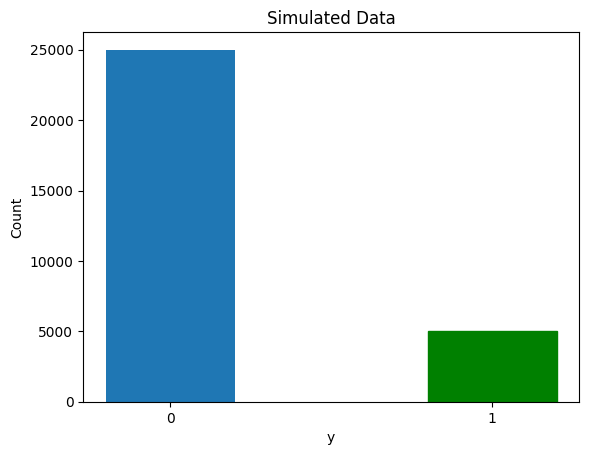

In [6]:
barlist = plt.bar([str(0),str(1)], data_total['Y'].value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("y")
plt.ylabel("Count")
plt.title("Simulated Data")
plt.show()

In [7]:
X = data_total.iloc[:,:-1]
y = data_total.iloc[:,-1]
X

0  1  2  3  4  5   6  7  8  9  10  11  12  13  14  15  16  17  18  19
0      1  1  1  0  1  1  11  9  7  8   0   0   2  -1  -2  -3   1   1   0   2
1      1  1  1  1  0  1  11  9  7  7   1  -1   1  -1   0   0  -1   2   2   0
2      0  1  1  0  1  1  11  9  7  8   1  -3  -1   0   0   0   0  -1  -2   0
3      1  1  1  1  1  1  11  9  7  8  -1   1   2   2   4   1   0  -3  -3   2
4      0  1  1  1  0  0  11  9  7  6   0  -7   4  -4  -1  -1  -3   2   4   3
...   .. .. .. .. .. ..  .. .. .. ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
29995  1  1  1  0  1  1  11  9  8  8  -1   1   0   3   0   4   3   3  -4   5
29996  0  1  1  1  0  1  11  9  7  8  -3   1  -3   1  -4   0   0   3   0  -2
29997  1  1  0  1  1  1  11  9  7  7  -1   0   6  -2   2   2  -2   3  -3  -1
29998  1  0  1  1  0  1  11  9  7  8  -1   2   1  -2  -2   0   3   1   0  -3
29999  0  1  0  1  1  1  11  9  7  8   1   6  -1   0  -3  -4   1  -2   1  -3

[30000 rows x 20 columns]

In [8]:
y

0        0
1        0
2        0
3        0
4        0
        ..
29995    1
29996    1
29997    1
29998    1
29999    1
Name: Y, Length: 30000, dtype: int64

In [8]:
# k = 5
# data_maj = data_balanced[data_balanced['Y']==0]
# data_min = data_balanced[data_balanced['Y']==1]

# data_min = data_min.sample(n=int(dataset_size/(2*k)), replace=False, random_state=10)
# data_min.shape

# data_total = pd.concat([data_maj, data_min]).reset_index(drop=True)
# data_total

# X = data_total.iloc[:,:-1]
# y = data_total.iloc[:,-1]
# y



In [9]:
X.shape

(30000, 20)

In [10]:
y.shape

(30000,)

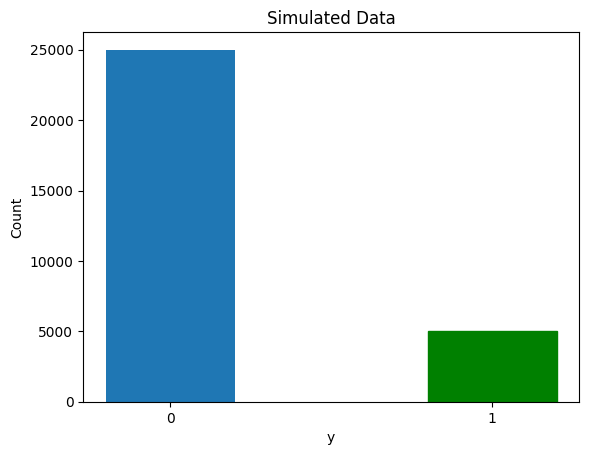

In [11]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("y")
plt.ylabel("Count")
plt.title("Simulated Data")
plt.show()

In [12]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)


X_scaled

0    1    2    3    4    5    6    7         8         9         10  \
0      1.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.666667  0.500000   
1      1.0  1.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.333333  0.545455   
2      0.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.666667  0.545455   
3      1.0  1.0  1.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.666667  0.454545   
4      0.0  1.0  1.0  1.0  0.0  0.0  0.5  0.5  0.666667  0.000000  0.500000   
...    ...  ...  ...  ...  ...  ...  ...  ...       ...       ...       ...   
29995  1.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  1.000000  0.666667  0.454545   
29996  0.0  1.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.666667  0.363636   
29997  1.0  1.0  0.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.333333  0.454545   
29998  1.0  0.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.666667  0.454545   
29999  0.0  1.0  0.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.666667  0.545455   

         11        12        13        14        15    16        17        18  \
0      0.50  0.583333  0.476190  0.409091  0.380952  0.50  0.523810  0.541667   
1      0.45  0.541667  0.476190  0.500000  0.523810  0.40  0.571429  0.625000   
2      0.35  0.458333  0.523810  0.500000  0.523810  0.45  0.428571  0.458333   
3      0.55  0.583333  0.619048  0.681818  0.571429  0.45  0.333333  0.416667   
4      0.15  0.666667  0.333333  0.454545  0.476190  0.30  0.571429  0.708333   
...     ...       ...       ...       ...       ...   ...       ...       ...   
29995  0.55  0.500000  0.666667  0.500000  0.714286  0.60  0.619048  0.375000   
29996  0.55  0.375000  0.571429  0.318182  0.523810  0.45  0.619048  0.541667   
29997  0.50  0.750000  0.428571  0.590909  0.619048  0.35  0.619048  0.416667   
29998  0.60  0.541667  0.428571  0.409091  0.523810  0.60  0.523810  0.541667   
29999  0.80  0.458333  0.523810  0.363636  0.333333  0.50  0.380952  0.583333   

             19  
0      0.545455  
1      0.454545  
2      0.454545  
3      0.545455  
4      0.590909  
...         ...  
29995  0.681818  
29996  0.363636  
29997  0.409091  
29998  0.318182  
29999  0.318182  

[30000 rows x 20 columns]

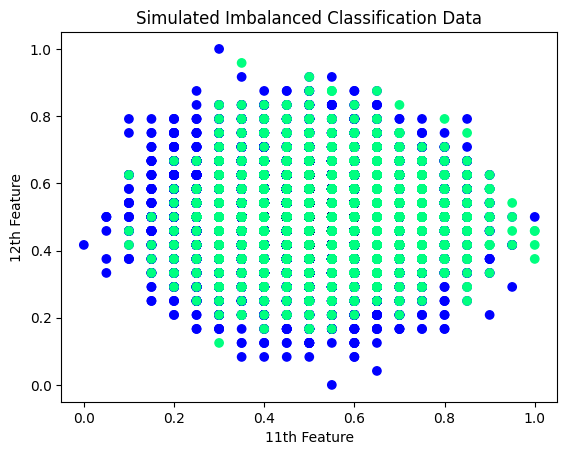

In [13]:
plt.scatter(X_scaled.iloc[:, 11], X_scaled.iloc[:, 12], c=y, cmap='winter')
plt.title('Simulated Imbalanced Classification Data')
plt.xlabel('11th Feature')
plt.ylabel('12th Feature')
plt.show()

In [14]:
data2 = pd.concat([X_scaled, y],axis=1)
data2

0    1    2    3    4    5    6    7         8         9  ...    11  \
0      1.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.50   
1      1.0  1.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.333333  ...  0.45   
2      0.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.35   
3      1.0  1.0  1.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.55   
4      0.0  1.0  1.0  1.0  0.0  0.0  0.5  0.5  0.666667  0.000000  ...  0.15   
...    ...  ...  ...  ...  ...  ...  ...  ...       ...       ...  ...   ...   
29995  1.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  1.000000  0.666667  ...  0.55   
29996  0.0  1.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.55   
29997  1.0  1.0  0.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.333333  ...  0.50   
29998  1.0  0.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.60   
29999  0.0  1.0  0.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.80   

             12        13        14        15    16        17        18  \
0      0.583333  0.476190  0.409091  0.380952  0.50  0.523810  0.541667   
1      0.541667  0.476190  0.500000  0.523810  0.40  0.571429  0.625000   
2      0.458333  0.523810  0.500000  0.523810  0.45  0.428571  0.458333   
3      0.583333  0.619048  0.681818  0.571429  0.45  0.333333  0.416667   
4      0.666667  0.333333  0.454545  0.476190  0.30  0.571429  0.708333   
...         ...       ...       ...       ...   ...       ...       ...   
29995  0.500000  0.666667  0.500000  0.714286  0.60  0.619048  0.375000   
29996  0.375000  0.571429  0.318182  0.523810  0.45  0.619048  0.541667   
29997  0.750000  0.428571  0.590909  0.619048  0.35  0.619048  0.416667   
29998  0.541667  0.428571  0.409091  0.523810  0.60  0.523810  0.541667   
29999  0.458333  0.523810  0.363636  0.333333  0.50  0.380952  0.583333   

             19  Y  
0      0.545455  0  
1      0.454545  0  
2      0.454545  0  
3      0.545455  0  
4      0.590909  0  
...         ... ..  
29995  0.681818  1  
29996  0.363636  1  
29997  0.409091  1  
29998  0.318182  1  
29999  0.318182  1  

[30000 rows x 21 columns]

In [15]:
y.value_counts()

Y
0    25000
1     5000
Name: count, dtype: int64

In [16]:
data2.iloc[:,0].value_counts()

0
1.0    23310
0.0     6690
Name: count, dtype: int64

In [17]:
print(len(data2[data2.iloc[:,0]<0.5]))
print(len(data2[data2.iloc[:,0]>=0.5]))

6690
23310


# Splitting for Source and Target Domains:


# Full Dataset:

In [18]:
data_S = data2[data2.iloc[:,0]>=0.5].reset_index(drop=True)  ## Source domain and classification
data_T = data2[data2.iloc[:,0]<0.5].reset_index(drop=True)  ## Target domain and classification

In [19]:
data_S

0    1    2    3    4    5    6    7         8         9  ...    11  \
0      1.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.50   
1      1.0  1.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.333333  ...  0.45   
2      1.0  1.0  1.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.55   
3      1.0  1.0  1.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.30   
4      1.0  1.0  0.0  1.0  1.0  0.5  0.5  0.5  0.333333  0.333333  ...  0.50   
...    ...  ...  ...  ...  ...  ...  ...  ...       ...       ...  ...   ...   
23305  1.0  1.0  0.0  0.0  1.0  0.5  0.5  0.5  0.333333  0.666667  ...  0.75   
23306  1.0  1.0  1.0  0.0  0.0  0.5  0.5  0.5  0.666667  0.333333  ...  0.50   
23307  1.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  1.000000  0.666667  ...  0.55   
23308  1.0  1.0  0.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.333333  ...  0.50   
23309  1.0  0.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.60   

             12        13        14        15    16        17        18  \
0      0.583333  0.476190  0.409091  0.380952  0.50  0.523810  0.541667   
1      0.541667  0.476190  0.500000  0.523810  0.40  0.571429  0.625000   
2      0.583333  0.619048  0.681818  0.571429  0.45  0.333333  0.416667   
3      0.375000  0.523810  0.318182  0.619048  0.25  0.571429  0.541667   
4      0.500000  0.619048  0.500000  0.619048  0.55  0.476190  0.500000   
...         ...       ...       ...       ...   ...       ...       ...   
23305  0.625000  0.619048  0.454545  0.523810  0.60  0.333333  0.541667   
23306  0.500000  0.476190  0.500000  0.523810  0.50  0.619048  0.541667   
23307  0.500000  0.666667  0.500000  0.714286  0.60  0.619048  0.375000   
23308  0.750000  0.428571  0.590909  0.619048  0.35  0.619048  0.416667   
23309  0.541667  0.428571  0.409091  0.523810  0.60  0.523810  0.541667   

             19  Y  
0      0.545455  0  
1      0.454545  0  
2      0.545455  0  
3      0.500000  0  
4      0.454545  0  
...         ... ..  
23305  0.318182  1  
23306  0.500000  1  
23307  0.681818  1  
23308  0.409091  1  
23309  0.318182  1  

[23310 rows x 21 columns]

In [20]:
data_T

0    1    2    3    4    5    6    7         8         9  ...    11  \
0     0.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.35   
1     0.0  1.0  1.0  1.0  0.0  0.0  0.5  0.5  0.666667  0.000000  ...  0.15   
2     0.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.75   
3     0.0  1.0  1.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.000000  ...  0.35   
4     0.0  1.0  0.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.333333  ...  0.65   
...   ...  ...  ...  ...  ...  ...  ...  ...       ...       ...  ...   ...   
6685  0.0  0.0  1.0  1.0  1.0  0.5  0.5  0.5  0.666667  1.000000  ...  0.50   
6686  0.0  1.0  0.0  1.0  1.0  0.5  0.5  0.0  0.666667  1.000000  ...  0.50   
6687  0.0  1.0  0.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.60   
6688  0.0  1.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.55   
6689  0.0  1.0  0.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.80   

            12        13        14        15    16        17        18  \
0     0.458333  0.523810  0.500000  0.523810  0.45  0.428571  0.458333   
1     0.666667  0.333333  0.454545  0.476190  0.30  0.571429  0.708333   
2     0.583333  0.476190  0.454545  0.476190  0.70  0.571429  0.291667   
3     0.625000  0.523810  0.454545  0.619048  0.45  0.523810  0.833333   
4     0.416667  0.666667  0.636364  0.619048  0.65  0.333333  0.541667   
...        ...       ...       ...       ...   ...       ...       ...   
6685  0.500000  0.571429  0.545455  0.619048  0.45  0.571429  0.375000   
6686  0.458333  0.523810  0.500000  0.476190  0.30  0.476190  0.333333   
6687  0.416667  0.523810  0.500000  0.619048  0.40  0.523810  0.458333   
6688  0.375000  0.571429  0.318182  0.523810  0.45  0.619048  0.541667   
6689  0.458333  0.523810  0.363636  0.333333  0.50  0.380952  0.583333   

            19  Y  
0     0.454545  0  
1     0.590909  0  
2     0.727273  0  
3     0.500000  0  
4     0.409091  0  
...        ... ..  
6685  0.500000  1  
6686  0.681818  1  
6687  0.363636  1  
6688  0.363636  1  
6689  0.318182  1  

[6690 rows x 21 columns]

## Source domain and task labels:

In [21]:
X_S_full = data_S.iloc[:, :-1]
X_S_full       ## Source domain


y_S_full = data_S.iloc[:, -1]
y_S_full       ## Source classification (response)

0        0
1        0
2        0
3        0
4        0
        ..
23305    1
23306    1
23307    1
23308    1
23309    1
Name: Y, Length: 23310, dtype: int64

In [22]:
y_S_full.value_counts()

Y
0    19400
1     3910
Name: count, dtype: int64

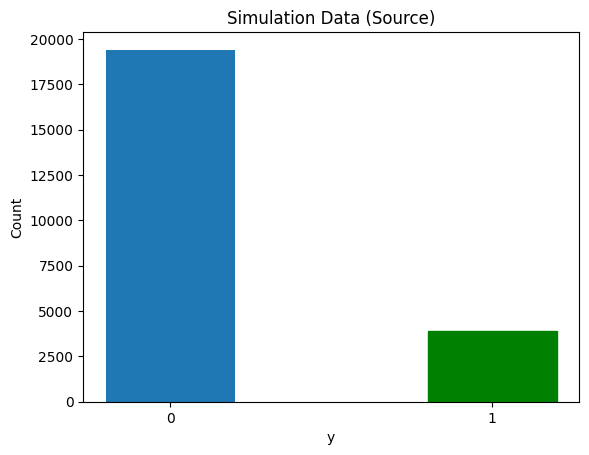

In [23]:
barlist_S = plt.bar([str(0),str(1)], y_S_full.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("y")
plt.ylabel("Count")
plt.title("Simulation Data (Source)")
plt.show()

## Target domain and task labels:

In [24]:
X_T_full = data_T.iloc[:, :-1]
X_T_full       ## Target domain


y_T_full = data_T.iloc[:, -1]
y_T_full       ## Target classification (response)

0       0
1       0
2       0
3       0
4       0
       ..
6685    1
6686    1
6687    1
6688    1
6689    1
Name: Y, Length: 6690, dtype: int64

In [25]:
y_T_full.value_counts()

Y
0    5600
1    1090
Name: count, dtype: int64

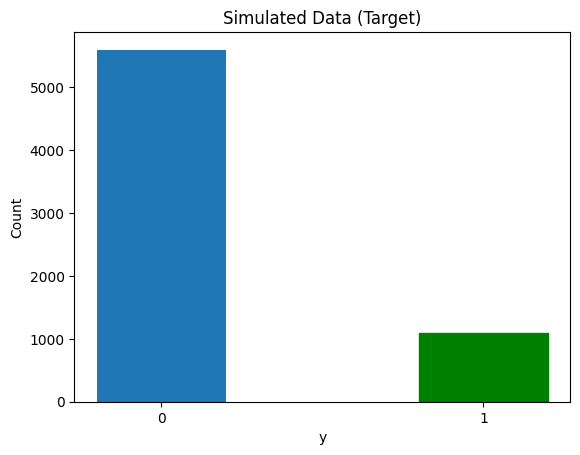

In [26]:
barlist_T = plt.bar([str(0),str(1)], y_T_full.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("y")
plt.ylabel("Count")
plt.title("Simulated Data (Target)")
plt.show()

In [27]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # # Confusion Matrix
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)
    return time_elapsed


In [28]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)

    return fpr, tnr, fnr, tpr, time_elapsed

In [29]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)

In [30]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (18648, 20)
y_S_train: (18648,)
X_S_test: (4662, 20)
y_S_test: (4662,)


In [31]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6128 - loss: 0.4505 - val_AUC: 0.7994 - val_loss: 0.3763
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8102 - loss: 0.3630 - val_AUC: 0.8531 - val_loss: 0.3260
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8530 - loss: 0.3223 - val_AUC: 0.8816 - val_loss: 0.2965
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8827 - loss: 0.2879 - val_AUC: 0.8958 - val_loss: 0.2760
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9057 - loss: 0.2694 - val_AUC: 0.9121 - val_loss: 0.2582
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9090 - loss: 0.2636 - val_AUC: 0.9231 - val_loss: 0.2661
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9259 - loss: 0.2393 - val_AUC: 0.9315 - val_loss: 0.2543
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9362 - loss: 0.2230 - val_AUC: 0.9405 - val_loss: 0.2515
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AU

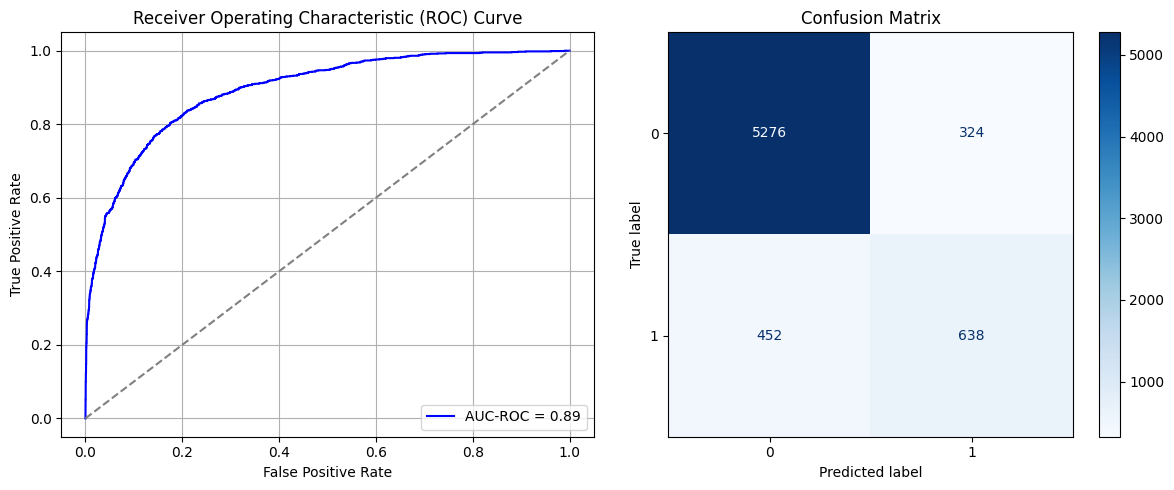

Best threshold based on F1-score: 0.3699893057346344
False Negative Rate: 0.41467889908256883
Time elapsed (performance): 0.82792195500042
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.5521 - loss: 0.5001 - val_AUC: 0.7967 - val_loss: 0.3912
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8092 - loss: 0.3600 - val_AUC: 0.8486 - val_loss: 0.3428
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8565 - loss: 0.3176 - val_AUC: 0.8708 - val_loss: 0.3176
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8818 - loss: 0.2900 - val_AUC: 0.8888 - val_loss: 0.2845
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8820 - loss: 0.2930 - val_AUC: 0.9041 - val_loss: 0.2732
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9124 - loss: 0.2556 - val_AUC: 0.9212 - val_loss: 0.2461
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9251 - loss: 0.2401 - val_AUC: 0.9334 - val_loss: 0.2291
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9305 - loss: 0.2291 - val_AUC: 0.9422 - val_loss: 0.2148
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9460 -

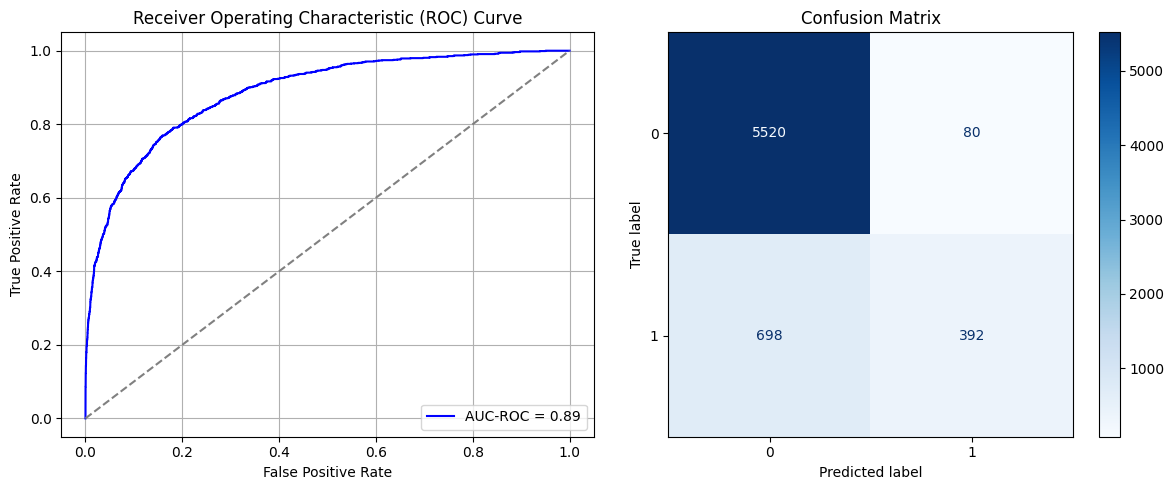

Best threshold based on F1-score: 0.22618448734283447
False Negative Rate: 0.6403669724770642
Time elapsed (performance): 1.0647764459990867
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6219 - loss: 0.4383 - val_AUC: 0.8218 - val_loss: 0.3789
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8285 - loss: 0.3451 - val_AUC: 0.8628 - val_loss: 0.3142
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8757 - loss: 0.2996 - val_AUC: 0.8862 - val_loss: 0.2864
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8891 - loss: 0.2790 - val_AUC: 0.9018 - val_loss: 0.2726
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9095 - loss: 0.2606 - val_AUC: 0.9172 - val_loss: 0.2463
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9162 - loss: 0.2507 - val_AUC: 0.9286 - val_loss: 0.2300
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9298 - loss: 0.2314 - val_AUC: 0.9404 - val_loss: 0.2236
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9436 - loss: 0.2122 - val_AUC: 0.9471 - val_loss: 0.2119
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9455 -

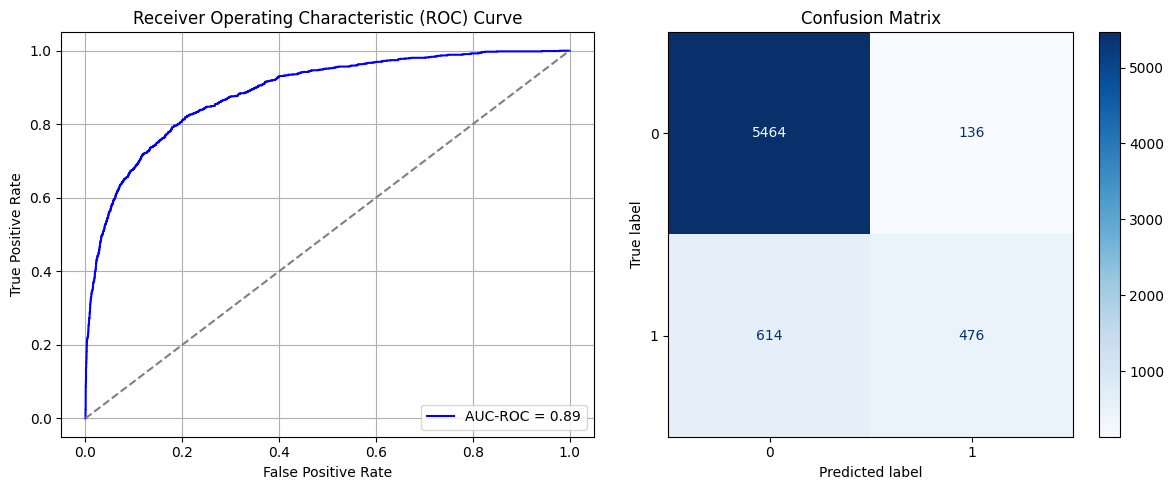

Best threshold based on F1-score: 0.23862849175930023
False Negative Rate: 0.563302752293578
Time elapsed (performance): 0.7832507840012113
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5658 - loss: 0.4726 - val_AUC: 0.7901 - val_loss: 0.3844
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8046 - loss: 0.3681 - val_AUC: 0.8506 - val_loss: 0.3275
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8549 - loss: 0.3198 - val_AUC: 0.8719 - val_loss: 0.3090
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8818 - loss: 0.2953 - val_AUC: 0.8898 - val_loss: 0.2852
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8973 - loss: 0.2775 - val_AUC: 0.9068 - val_loss: 0.2601
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9160 - loss: 0.2541 - val_AUC: 0.9262 - val_loss: 0.2377
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9333 - loss: 0.2261 - val_AUC: 0.9353 - val_loss: 0.2248
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9415 - loss: 0.2111 - val_AUC: 0.9427 - val_loss: 0.2101
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9432 -

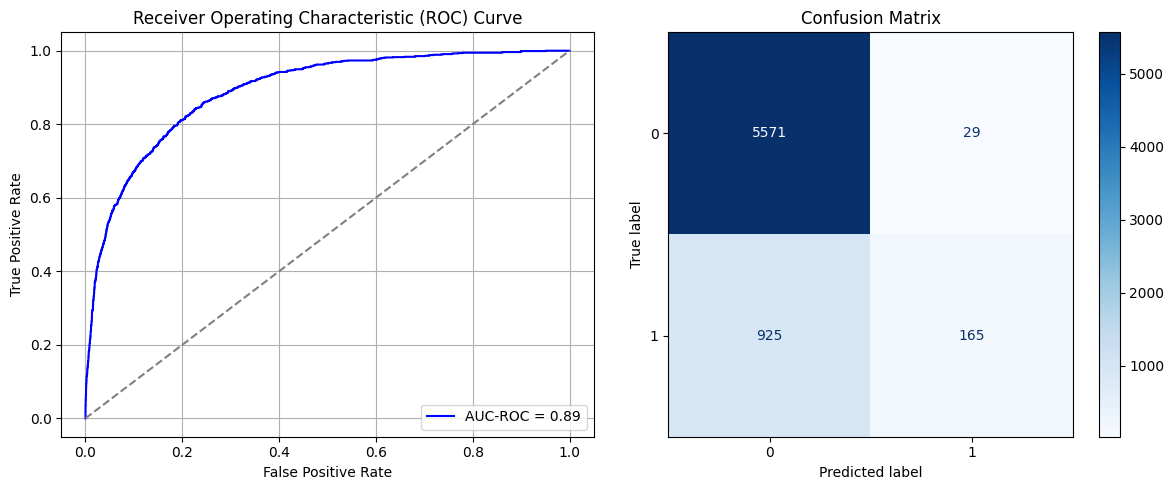

Best threshold based on F1-score: 0.05322776734828949
False Negative Rate: 0.8486238532110092
Time elapsed (performance): 0.802821863000645
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5890 - loss: 0.4386 - val_AUC: 0.8318 - val_loss: 0.3550
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8313 - loss: 0.3467 - val_AUC: 0.8839 - val_loss: 0.3009
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8956 - loss: 0.2831 - val_AUC: 0.9042 - val_loss: 0.2715
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9046 - loss: 0.2654 - val_AUC: 0.9231 - val_loss: 0.2484
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9313 - loss: 0.2309 - val_AUC: 0.9328 - val_loss: 0.2393
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9400 - loss: 0.2199 - val_AUC: 0.9408 - val_loss: 0.2282
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9429 - loss: 0.2095 - val_AUC: 0.9461 - val_loss: 0.2043
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9471 - loss: 0.2018 - val_AUC: 0.9561 - val_loss: 0.1922
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9565 -

Best threshold based on F1-score: 0.3092022240161896
False Negative Rate: 0.5293577981651376
Time elapsed (performance): 0.8922426760000235
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.6127 - loss: 0.4455 - val_AUC: 0.8225 - val_loss: 0.3667
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8297 - loss: 0.3514 - val_AUC: 0.8736 - val_loss: 0.3107
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8793 - loss: 0.3034 - val_AUC: 0.8938 - val_loss: 0.3005
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9062 - loss: 0.2721 - val_AUC: 0.9103 - val_loss: 0.2632
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9142 - loss: 0.2590 - val_AUC: 0.9236 - val_loss: 0.2563
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9203 - loss: 0.2460 - val_AUC: 0.9333 - val_loss: 0.2279
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9363 - loss: 0.2203 - val_AUC: 0.9387 - val_loss: 0.2372
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9380 - loss: 0.2201 - val_AUC: 0.9457 - val_loss: 0.2065
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9449 -

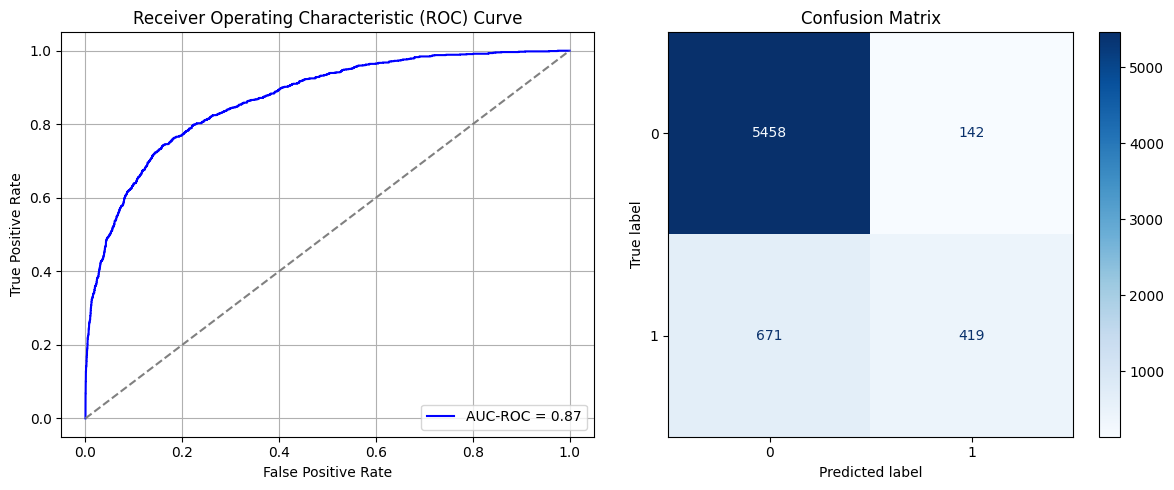

Best threshold based on F1-score: 0.2277432084083557
False Negative Rate: 0.6155963302752293
Time elapsed (performance): 1.027350069000022
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.5967 - loss: 0.4548 - val_AUC: 0.8077 - val_loss: 0.3828
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8197 - loss: 0.3523 - val_AUC: 0.8717 - val_loss: 0.3107
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8789 - loss: 0.3033 - val_AUC: 0.8953 - val_loss: 0.2831
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9044 - loss: 0.2692 - val_AUC: 0.9113 - val_loss: 0.2720
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9147 - loss: 0.2449 - val_AUC: 0.9271 - val_loss: 0.2426
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9321 - loss: 0.2303 - val_AUC: 0.9359 - val_loss: 0.2217
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9433 - loss: 0.2105 - val_AUC: 0.9442 - val_loss: 0.2116
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9473 - loss: 0.2038 - val_AUC: 0.9507 - val_loss: 0.2014
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9525 -

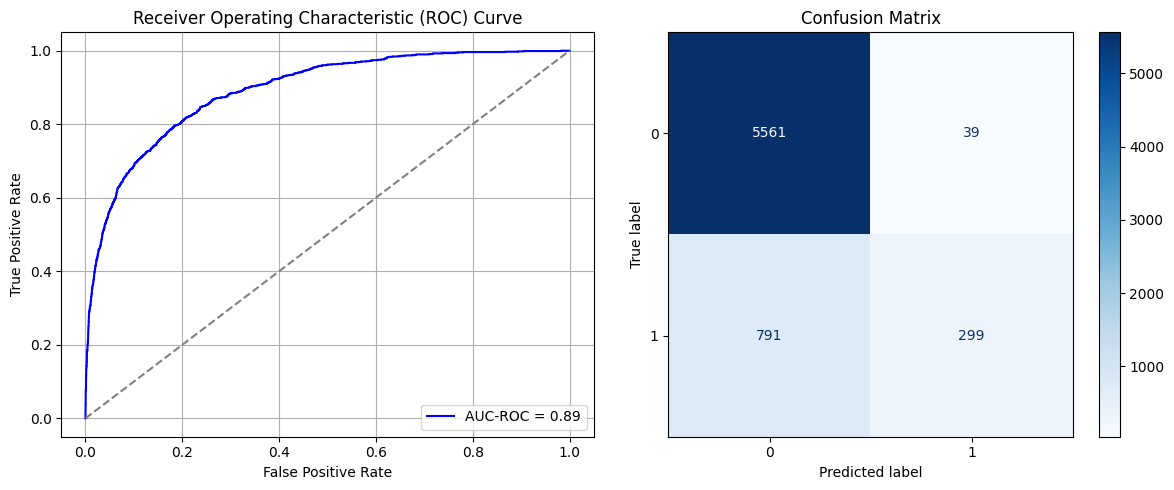

Best threshold based on F1-score: 0.09969890862703323
False Negative Rate: 0.7256880733944954
Time elapsed (performance): 1.2687665480007126


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5640 - loss: 0.4849 - val_AUC: 0.8067 - val_loss: 0.3662
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8250 - loss: 0.3541 - val_AUC: 0.8769 - val_loss: 0.3009
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8919 - loss: 0.2822 - val_AUC: 0.9020 - val_loss: 0.2705
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9020 - loss: 0.2695 - val_AUC: 0.9228 - val_loss: 0.2501
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9190 - loss: 0.2468 - val_AUC: 0.9339 - val_loss: 0.2365
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9329 - loss: 0.2242 - val_AUC: 0.9440 - val_loss: 0.2130
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9443 - loss: 0.2101 - val_AUC: 0.9517 - val_loss: 0.2401
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9534 - loss: 0.1921 - val_AUC: 0.9558 - val_loss: 0.1901
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AU

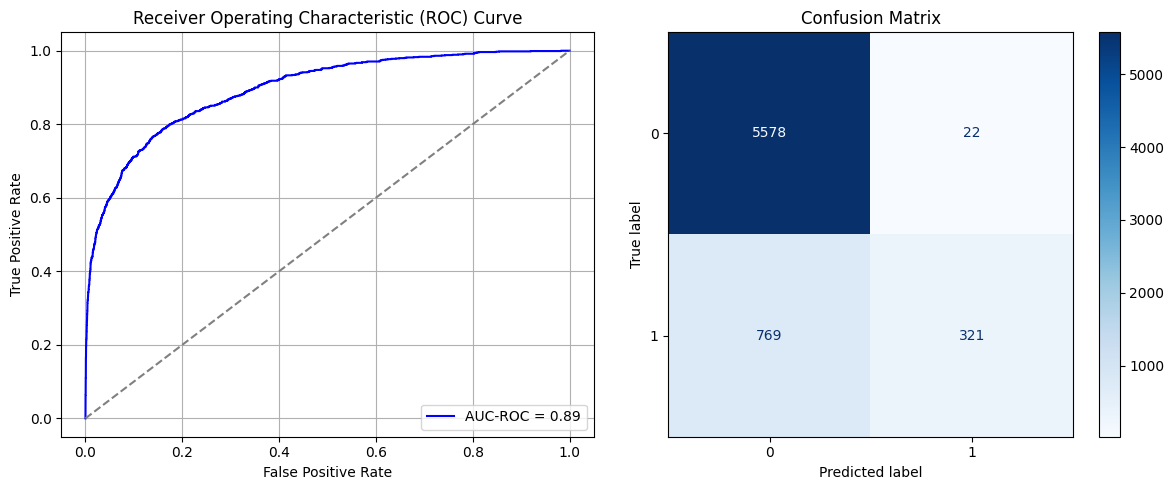

Best threshold based on F1-score: 0.0567779615521431
False Negative Rate: 0.7055045871559633
Time elapsed (performance): 1.2785901820006984
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6260 - loss: 0.4544 - val_AUC: 0.8113 - val_loss: 0.3679
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8244 - loss: 0.3469 - val_AUC: 0.8661 - val_loss: 0.3229
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8700 - loss: 0.3008 - val_AUC: 0.8823 - val_loss: 0.2923
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8945 - loss: 0.2775 - val_AUC: 0.9058 - val_loss: 0.2838
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9075 - loss: 0.2707 - val_AUC: 0.9169 - val_loss: 0.2532
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9224 - loss: 0.2405 - val_AUC: 0.9290 - val_loss: 0.2353
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9275 - loss: 0.2374 - val_AUC: 0.9375 - val_loss: 0.2306
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9383 - loss: 0.2190 - val_AUC: 0.9426 - val_loss: 0.2129
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9466 -

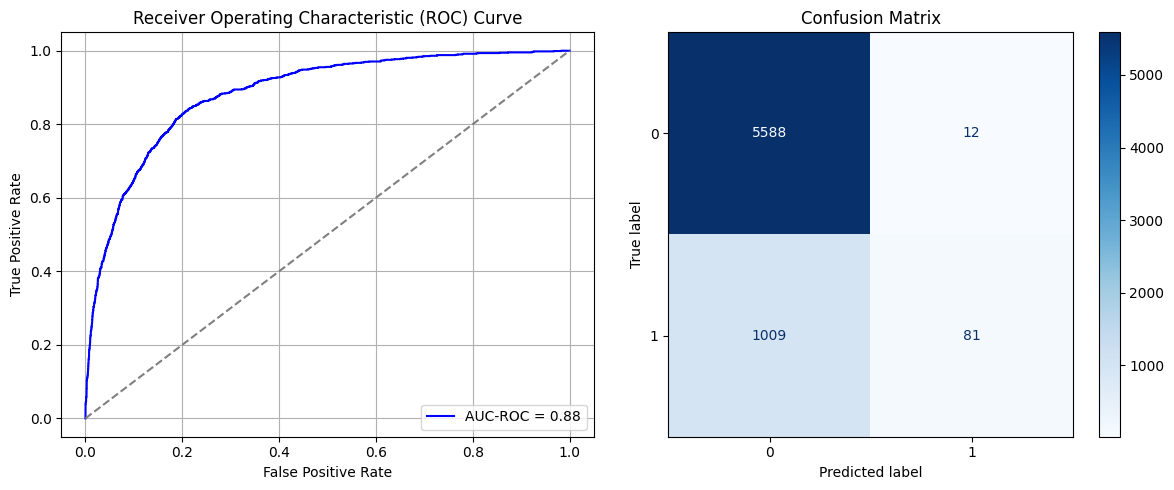

Best threshold based on F1-score: 0.014891219325363636
False Negative Rate: 0.9256880733944954
Time elapsed (performance): 1.086837030999959
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.5938 - loss: 0.4515 - val_AUC: 0.8072 - val_loss: 0.3786
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8156 - loss: 0.3650 - val_AUC: 0.8666 - val_loss: 0.3142
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8691 - loss: 0.3052 - val_AUC: 0.8937 - val_loss: 0.2812
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8947 - loss: 0.2749 - val_AUC: 0.9111 - val_loss: 0.2561
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9153 - loss: 0.2517 - val_AUC: 0.9255 - val_loss: 0.2416
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.9376 - loss: 0.2219 - val_AUC: 0.9320 - val_loss: 0.2274
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9391 - loss: 0.2136 - val_AUC: 0.9425 - val_loss: 0.2086
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9484 - loss: 0.1980 - val_AUC: 0.9458 - val_loss: 0.2303
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9535 -

Best threshold based on F1-score: 0.8723080158233643
False Negative Rate: 0.12752293577981652
Time elapsed (performance): 1.1299732010011212


In [32]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)
    model_source = create_dnn_model(X_S_train.shape[1])
    result_imbalanced = train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_imbalanced = Transductive_TL(model_source, X_T_full, y_T_full, "Target")

    Training_time.append(result_imbalanced)
    FPR.append(result_TL_imbalanced[0])
    TNR.append(result_TL_imbalanced[1])
    FNR.append(result_TL_imbalanced[2])
    TPR.append(result_TL_imbalanced[3])
    TL_time.append(result_TL_imbalanced[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

In [33]:
print('Mean:', ParamFit['FNR'].mean())
print('Variance:', ParamFit['FNR'].var())

Mean: 0.6096330275229357
Variance: 0.051075059151399524


In [34]:
print(ParamFit)
ParamFit.to_csv('Imbalanced.csv')


   Source time       FPR       TPR       FNR       TNR  Target time
0    23.965441  0.057857  0.585321  0.414679  0.942143     0.827922
1    24.698464  0.014286  0.359633  0.640367  0.985714     1.064776
2    27.259305  0.024286  0.436697  0.563303  0.975714     0.783251
3    23.517811  0.005179  0.151376  0.848624  0.994821     0.802822
4    26.480465  0.044286  0.470642  0.529358  0.955714     0.892243
5    26.182743  0.025357  0.384404  0.615596  0.974643     1.027350
6    25.125903  0.006964  0.274312  0.725688  0.993036     1.268767
7    22.254995  0.003929  0.294495  0.705505  0.996071     1.278590
8    22.939697  0.002143  0.074312  0.925688  0.997857     1.086837
9    24.508569  0.398214  0.872477  0.127523  0.601786     1.129973


# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [35]:
data_S

0    1    2    3    4    5    6    7         8         9  ...    11  \
0      1.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.50   
1      1.0  1.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.333333  ...  0.45   
2      1.0  1.0  1.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.55   
3      1.0  1.0  1.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.30   
4      1.0  1.0  0.0  1.0  1.0  0.5  0.5  0.5  0.333333  0.333333  ...  0.50   
...    ...  ...  ...  ...  ...  ...  ...  ...       ...       ...  ...   ...   
23305  1.0  1.0  0.0  0.0  1.0  0.5  0.5  0.5  0.333333  0.666667  ...  0.75   
23306  1.0  1.0  1.0  0.0  0.0  0.5  0.5  0.5  0.666667  0.333333  ...  0.50   
23307  1.0  1.0  1.0  0.0  1.0  0.5  0.5  0.5  1.000000  0.666667  ...  0.55   
23308  1.0  1.0  0.0  1.0  1.0  0.5  0.5  0.5  0.666667  0.333333  ...  0.50   
23309  1.0  0.0  1.0  1.0  0.0  0.5  0.5  0.5  0.666667  0.666667  ...  0.60   

             12        13        14        15    16        17        18  \
0      0.583333  0.476190  0.409091  0.380952  0.50  0.523810  0.541667   
1      0.541667  0.476190  0.500000  0.523810  0.40  0.571429  0.625000   
2      0.583333  0.619048  0.681818  0.571429  0.45  0.333333  0.416667   
3      0.375000  0.523810  0.318182  0.619048  0.25  0.571429  0.541667   
4      0.500000  0.619048  0.500000  0.619048  0.55  0.476190  0.500000   
...         ...       ...       ...       ...   ...       ...       ...   
23305  0.625000  0.619048  0.454545  0.523810  0.60  0.333333  0.541667   
23306  0.500000  0.476190  0.500000  0.523810  0.50  0.619048  0.541667   
23307  0.500000  0.666667  0.500000  0.714286  0.60  0.619048  0.375000   
23308  0.750000  0.428571  0.590909  0.619048  0.35  0.619048  0.416667   
23309  0.541667  0.428571  0.409091  0.523810  0.60  0.523810  0.541667   

             19  Y  
0      0.545455  0  
1      0.454545  0  
2      0.545455  0  
3      0.500000  0  
4      0.454545  0  
...         ... ..  
23305  0.318182  1  
23306  0.500000  1  
23307  0.681818  1  
23308  0.409091  1  
23309  0.318182  1  

[23310 rows x 21 columns]

In [36]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

3910
19400


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - AUC: 0.6147 - loss: 0.6737 - val_AUC: 0.7220 - val_loss: 0.6313
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7640 - loss: 0.5939 - val_AUC: 0.8193 - val_loss: 0.5340
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8269 - loss: 0.5220 - val_AUC: 0.8641 - val_loss: 0.4759
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8532 - loss: 0.4820 - val_AUC: 0.8873 - val_loss: 0.4399
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8735 - loss: 0.4512 - val_AUC: 0.8987 - val_loss: 0.4251
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8836 - loss: 0.4337 - val_AUC: 0.9086 - val_loss: 0.3984
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4167 - val_AUC: 0.9145 - val_loss: 0.3829
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9037 - loss: 0.3955 - val_AUC: 0.9185 - val_loss: 0.3810
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - A

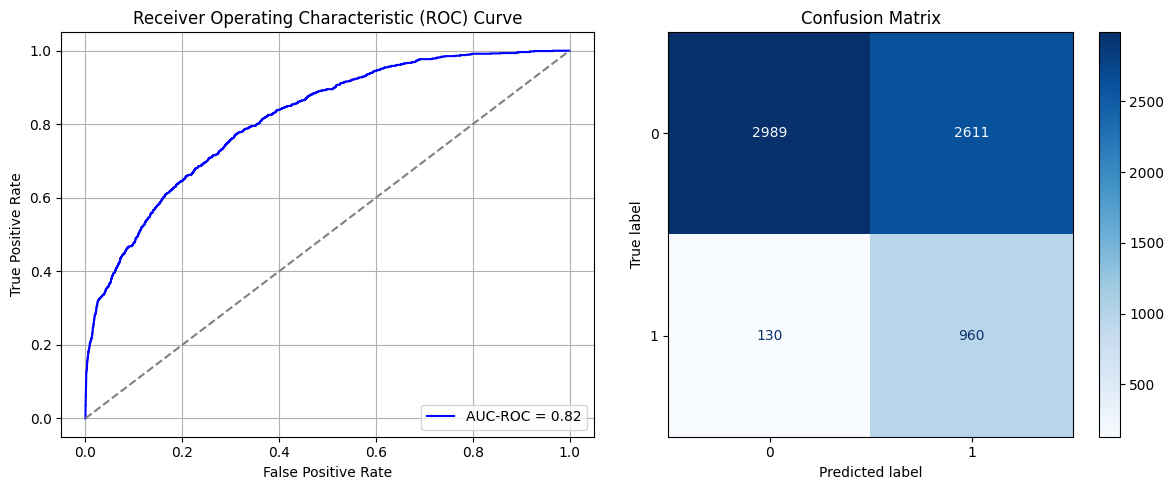

Best threshold based on F1-score: 0.8234160542488098
False Negative Rate: 0.11926605504587157
Time elapsed (performance): 0.8095301249995828
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6217 - loss: 0.6735 - val_AUC: 0.7208 - val_loss: 0.6257
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7496 - loss: 0.6043 - val_AUC: 0.8174 - val_loss: 0.5561
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8266 - loss: 0.5279 - val_AUC: 0.8620 - val_loss: 0.4914
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8572 - loss: 0.4813 - val_AUC: 0.8849 - val_loss: 0.4617
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4397 - val_AUC: 0.8956 - val_loss: 0.4283
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8968 - loss: 0.4156 - val_AUC: 0.9046 - val_loss: 0.4029
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9060 - loss: 0.3978 - val_AUC: 0.9097 - val_loss: 0.3876
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9090 - loss: 0.3877 - val_AUC: 0.9197 - val_loss: 0.3963
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9092 -

Best threshold based on F1-score: 0.8342016339302063
False Negative Rate: 0.044954128440366975
Time elapsed (performance): 1.0475487540006725
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6004 - loss: 0.6808 - val_AUC: 0.7755 - val_loss: 0.5861
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7787 - loss: 0.5754 - val_AUC: 0.8422 - val_loss: 0.5111
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8342 - loss: 0.5120 - val_AUC: 0.8762 - val_loss: 0.4781
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8654 - loss: 0.4682 - val_AUC: 0.8905 - val_loss: 0.4363
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8776 - loss: 0.4463 - val_AUC: 0.9037 - val_loss: 0.4118
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4295 - val_AUC: 0.9093 - val_loss: 0.4010
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8943 - loss: 0.4140 - val_AUC: 0.9184 - val_loss: 0.3844
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9095 - loss: 0.3857 - val_AUC: 0.9244 - val_loss: 0.3650
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9173 -

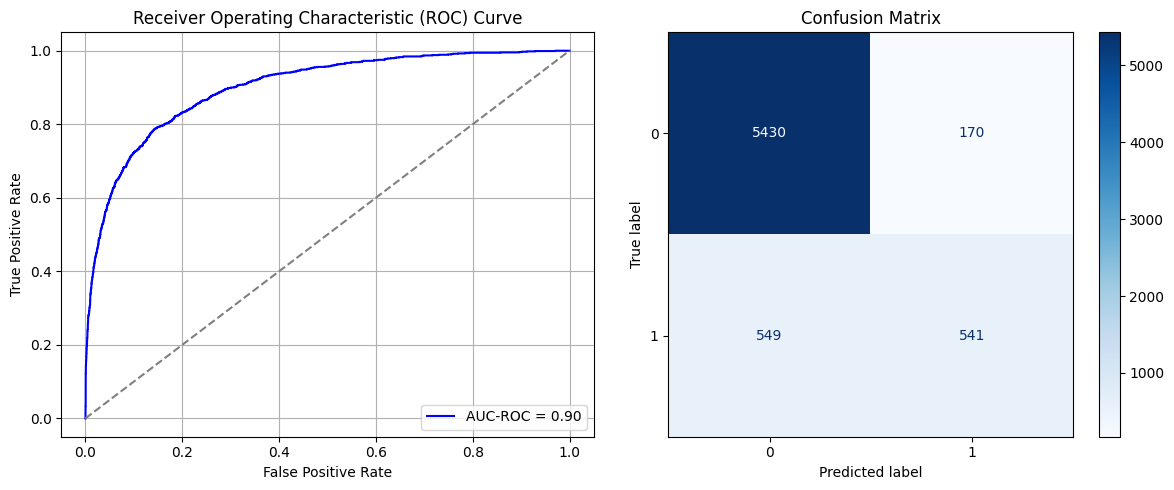

Best threshold based on F1-score: 0.3608766794204712
False Negative Rate: 0.5036697247706422
Time elapsed (performance): 0.8512733579991618
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6099 - loss: 0.6723 - val_AUC: 0.7609 - val_loss: 0.5982
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7705 - loss: 0.5859 - val_AUC: 0.8443 - val_loss: 0.5148
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8301 - loss: 0.5201 - val_AUC: 0.8870 - val_loss: 0.4736
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8789 - loss: 0.4533 - val_AUC: 0.8986 - val_loss: 0.4188
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8879 - loss: 0.4292 - val_AUC: 0.9047 - val_loss: 0.3995
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9088 - loss: 0.3877 - val_AUC: 0.9137 - val_loss: 0.3812
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9094 - loss: 0.3826 - val_AUC: 0.9224 - val_loss: 0.3730
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9203 - loss: 0.3636 - val_AUC: 0.9277 - val_loss: 0.3669
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9280 -

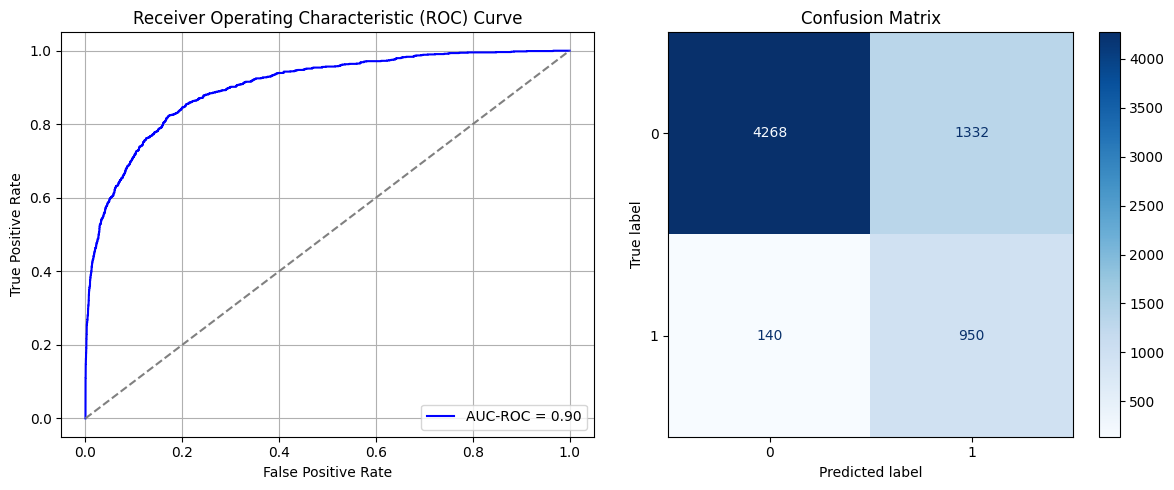

Best threshold based on F1-score: 0.816562294960022
False Negative Rate: 0.12844036697247707
Time elapsed (performance): 0.9948427790004644
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.5932 - loss: 0.6733 - val_AUC: 0.7656 - val_loss: 0.6023
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7795 - loss: 0.5813 - val_AUC: 0.8319 - val_loss: 0.5275
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8285 - loss: 0.5243 - val_AUC: 0.8610 - val_loss: 0.4938
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8565 - loss: 0.4802 - val_AUC: 0.8732 - val_loss: 0.4561
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8781 - loss: 0.4447 - val_AUC: 0.8868 - val_loss: 0.4466
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8897 - loss: 0.4241 - val_AUC: 0.8941 - val_loss: 0.4268
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8872 - loss: 0.4265 - val_AUC: 0.9010 - val_loss: 0.4076
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8934 - loss: 0.4129 - val_AUC: 0.9081 - val_loss: 0.3932
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9115 -

Best threshold based on F1-score: 0.9740325212478638
False Negative Rate: 0.027522935779816515
Time elapsed (performance): 1.0812412159993983
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6216 - loss: 0.6697 - val_AUC: 0.7428 - val_loss: 0.6099
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7681 - loss: 0.5867 - val_AUC: 0.8124 - val_loss: 0.5479
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8336 - loss: 0.5180 - val_AUC: 0.8548 - val_loss: 0.5073
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8617 - loss: 0.4752 - val_AUC: 0.8861 - val_loss: 0.4402
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.8914 - loss: 0.4279 - val_AUC: 0.9000 - val_loss: 0.4807
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8934 - loss: 0.4184 - val_AUC: 0.9142 - val_loss: 0.3908
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9113 - loss: 0.3851 - val_AUC: 0.9198 - val_loss: 0.3716
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9195 - loss: 0.3658 - val_AUC: 0.9259 - val_loss: 0.3582
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9238 -

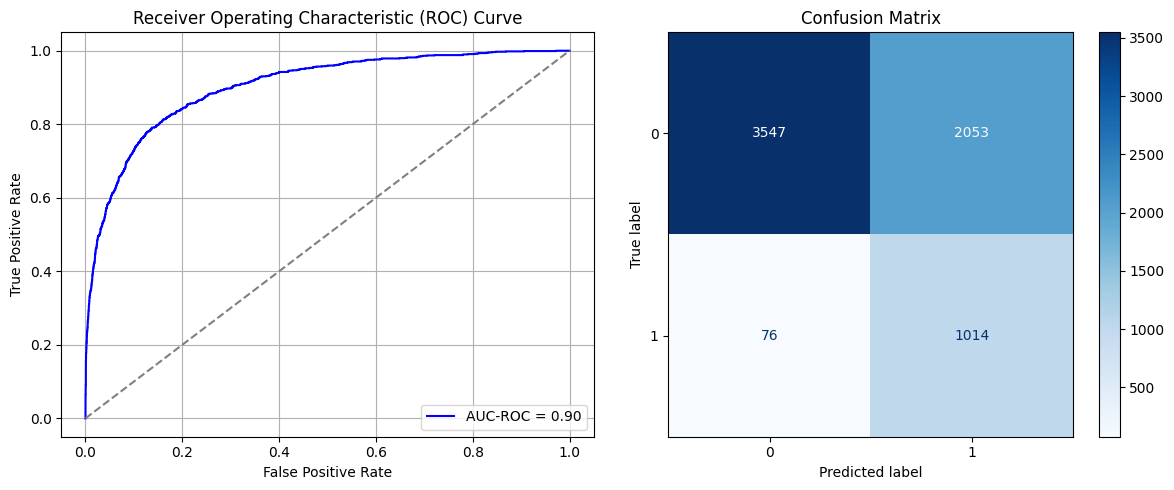

Best threshold based on F1-score: 0.8508415222167969
False Negative Rate: 0.06972477064220184
Time elapsed (performance): 1.1309470319993125
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5914 - loss: 0.6789 - val_AUC: 0.7418 - val_loss: 0.6169
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7379 - loss: 0.6118 - val_AUC: 0.8092 - val_loss: 0.5677
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8003 - loss: 0.5529 - val_AUC: 0.8622 - val_loss: 0.4989
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8504 - loss: 0.4932 - val_AUC: 0.8741 - val_loss: 0.4762
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8597 - loss: 0.4717 - val_AUC: 0.8833 - val_loss: 0.4478
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8805 - loss: 0.4391 - val_AUC: 0.8906 - val_loss: 0.4361
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8923 - loss: 0.4191 - val_AUC: 0.9044 - val_loss: 0.4138
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9096 - loss: 0.3877 - val_AUC: 0.9069 - val_loss: 0.4034
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9082 -

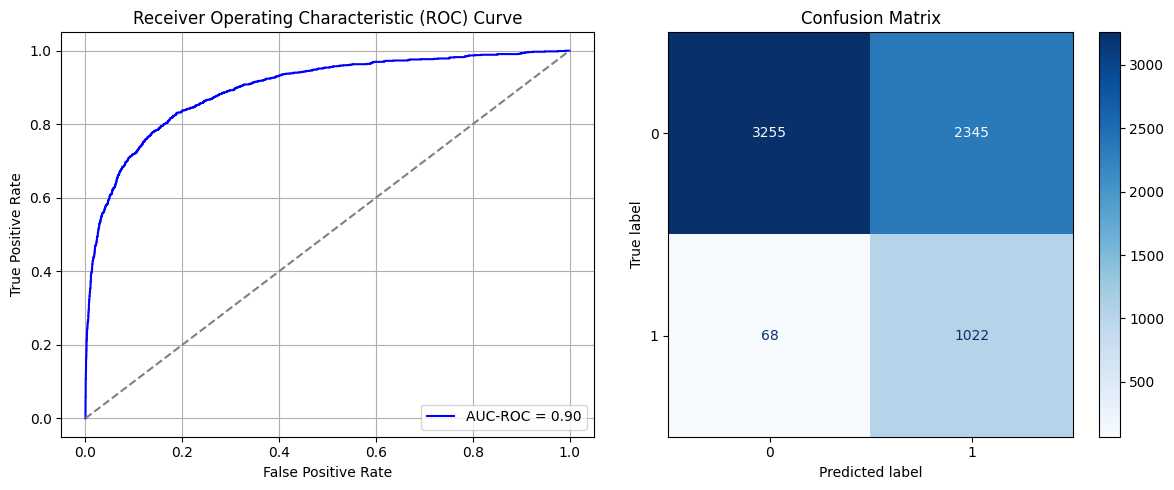

Best threshold based on F1-score: 0.8702621459960938
False Negative Rate: 0.062385321100917435
Time elapsed (performance): 0.8315219079995586
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6044 - loss: 0.6748 - val_AUC: 0.7405 - val_loss: 0.6114
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7502 - loss: 0.5996 - val_AUC: 0.7932 - val_loss: 0.5550
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8211 - loss: 0.5279 - val_AUC: 0.8555 - val_loss: 0.4892
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8496 - loss: 0.4890 - val_AUC: 0.8666 - val_loss: 0.4599
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8687 - loss: 0.4577 - val_AUC: 0.8918 - val_loss: 0.4254
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8928 - loss: 0.4189 - val_AUC: 0.8979 - val_loss: 0.4364
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9035 - loss: 0.3988 - val_AUC: 0.9057 - val_loss: 0.4079
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9203 - loss: 0.3660 - val_AUC: 0.9224 - val_loss: 0.3625
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9285 -

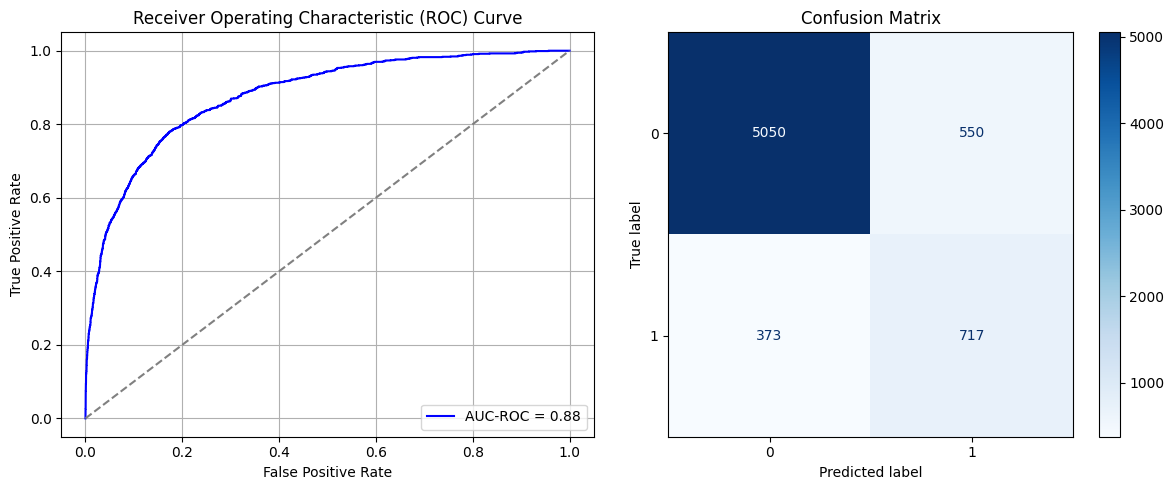

Best threshold based on F1-score: 0.5080018043518066
False Negative Rate: 0.3422018348623853
Time elapsed (performance): 0.8538661879993015
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6399 - loss: 0.6642 - val_AUC: 0.7657 - val_loss: 0.6023
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7785 - loss: 0.5758 - val_AUC: 0.8312 - val_loss: 0.5349
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8307 - loss: 0.5210 - val_AUC: 0.8664 - val_loss: 0.4836
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8627 - loss: 0.4772 - val_AUC: 0.8769 - val_loss: 0.4697
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8751 - loss: 0.4503 - val_AUC: 0.8999 - val_loss: 0.4153
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9019 - loss: 0.4058 - val_AUC: 0.9101 - val_loss: 0.3912
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.9097 - loss: 0.3860 - val_AUC: 0.9168 - val_loss: 0.3772
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.9158 - loss: 0.3756 - val_AUC: 0.9279 - val_loss: 0.3534
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9280 -

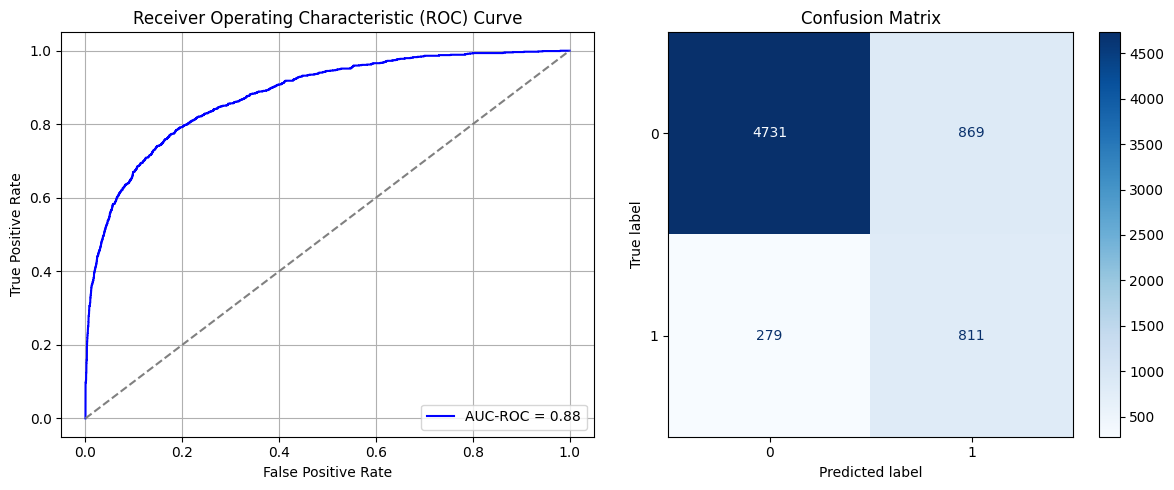

Best threshold based on F1-score: 0.7339792251586914
False Negative Rate: 0.25596330275229356
Time elapsed (performance): 0.9743019600009575
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6605 - loss: 0.6625 - val_AUC: 0.7721 - val_loss: 0.5960
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7837 - loss: 0.5765 - val_AUC: 0.8376 - val_loss: 0.5289
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8368 - loss: 0.5162 - val_AUC: 0.8644 - val_loss: 0.4779
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8577 - loss: 0.4776 - val_AUC: 0.8750 - val_loss: 0.4540
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8765 - loss: 0.4485 - val_AUC: 0.8888 - val_loss: 0.4309
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8880 - loss: 0.4275 - val_AUC: 0.8968 - val_loss: 0.4216
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8971 - loss: 0.4112 - val_AUC: 0.9072 - val_loss: 0.3946
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9064 - loss: 0.3921 - val_AUC: 0.9131 - val_loss: 0.3838
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9183 -

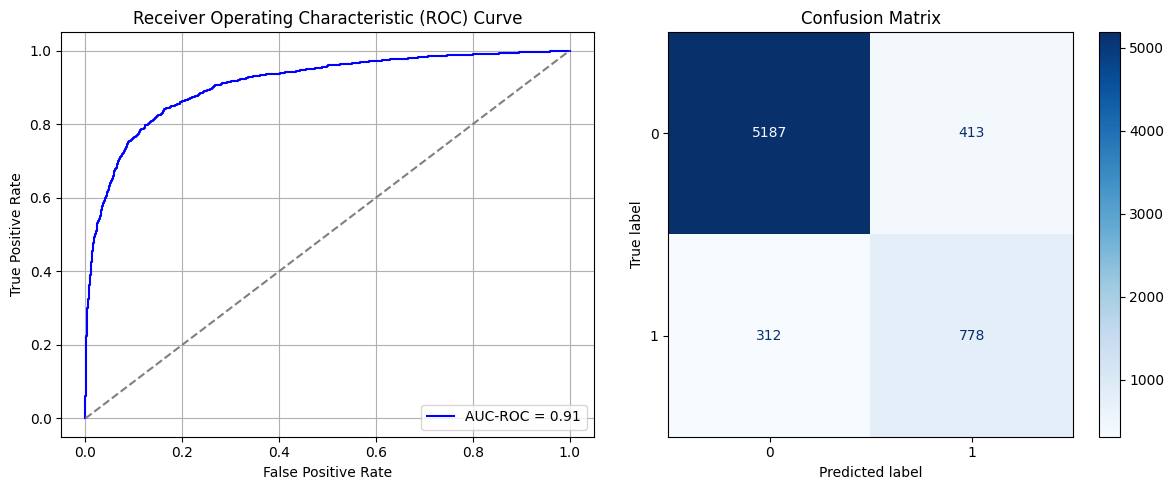

Best threshold based on F1-score: 0.5119116902351379
False Negative Rate: 0.28623853211009176
Time elapsed (performance): 0.8605069049990561


In [37]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=False)
    data_S_SRS_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRS = data_S_SRS_RUS.iloc[:, :-1]
    y_S_SRS = data_S_SRS_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
    model_SRS = create_dnn_model(X_S_train.shape[1])
    result_SRS = train_and_evaluate(model_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS = Transductive_TL(model_SRS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS)
    FPR.append(result_TL_SRS[0])
    TNR.append(result_TL_SRS[1])
    FNR.append(result_TL_SRS[2])
    TPR.append(result_TL_SRS[3])
    TL_time.append(result_TL_SRS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

In [38]:
print('Mean:', ParamFit['FNR'].mean())
print('Variance:', ParamFit['FNR'].var())

Mean: 0.1840366972477064
Variance: 0.024643679450850567


In [39]:
print(ParamFit)
ParamFit.to_csv('SRS_RUS.csv')

   Source time       FPR       TPR       FNR       TNR  Target time
0    11.956199  0.466250  0.880734  0.119266  0.533750     0.809530
1     9.818168  0.433036  0.955046  0.044954  0.566964     1.047549
2    10.228388  0.030357  0.496330  0.503670  0.969643     0.851273
3    12.045681  0.237857  0.871560  0.128440  0.762143     0.994843
4    10.029636  0.809643  0.972477  0.027523  0.190357     1.081241
5    11.405898  0.366607  0.930275  0.069725  0.633393     1.130947
6    11.686489  0.418750  0.937615  0.062385  0.581250     0.831522
7    11.333790  0.098214  0.657798  0.342202  0.901786     0.853866
8    11.375630  0.155179  0.744037  0.255963  0.844821     0.974302
9    11.115099  0.073750  0.713761  0.286239  0.926250     0.860507


## Simple Random Sampling with Replacement:

In [40]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

3910
19400


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6324 - loss: 0.6706 - val_AUC: 0.7567 - val_loss: 0.6001
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7668 - loss: 0.5846 - val_AUC: 0.8407 - val_loss: 0.5335
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8330 - loss: 0.5143 - val_AUC: 0.8700 - val_loss: 0.5149
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8675 - loss: 0.4653 - val_AUC: 0.8932 - val_loss: 0.4693
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4293 - val_AUC: 0.9011 - val_loss: 0.4236
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4204 - val_AUC: 0.9081 - val_loss: 0.3928
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8998 - loss: 0.4014 - val_AUC: 0.9227 - val_loss: 0.3734
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9138 - loss: 0.3755 - val_AUC: 0.9257 - val_loss: 0.3770
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9253 -

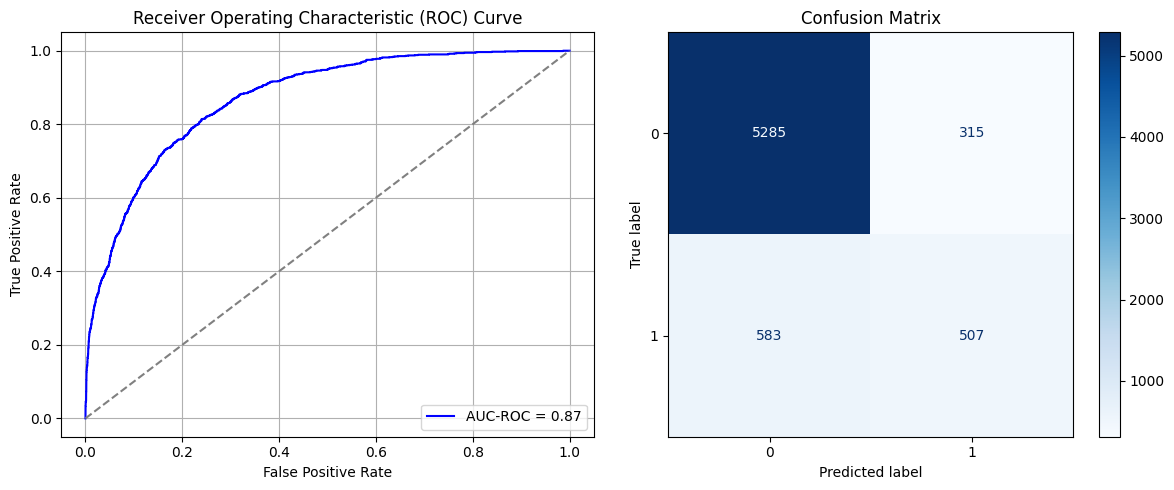

Best threshold based on F1-score: 0.291373074054718
False Negative Rate: 0.5348623853211009
Time elapsed (performance): 1.061010706000161
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5763 - loss: 0.6877 - val_AUC: 0.7469 - val_loss: 0.6095
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7598 - loss: 0.5971 - val_AUC: 0.8207 - val_loss: 0.5352
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8152 - loss: 0.5339 - val_AUC: 0.8588 - val_loss: 0.4916
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8510 - loss: 0.4868 - val_AUC: 0.8842 - val_loss: 0.4438
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8708 - loss: 0.4560 - val_AUC: 0.8946 - val_loss: 0.4354
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8852 - loss: 0.4301 - val_AUC: 0.9090 - val_loss: 0.3991
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8953 - loss: 0.4130 - val_AUC: 0.9135 - val_loss: 0.3862
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9095 - loss: 0.3845 - val_AUC: 0.9193 - val_loss: 0.3760
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9080 -

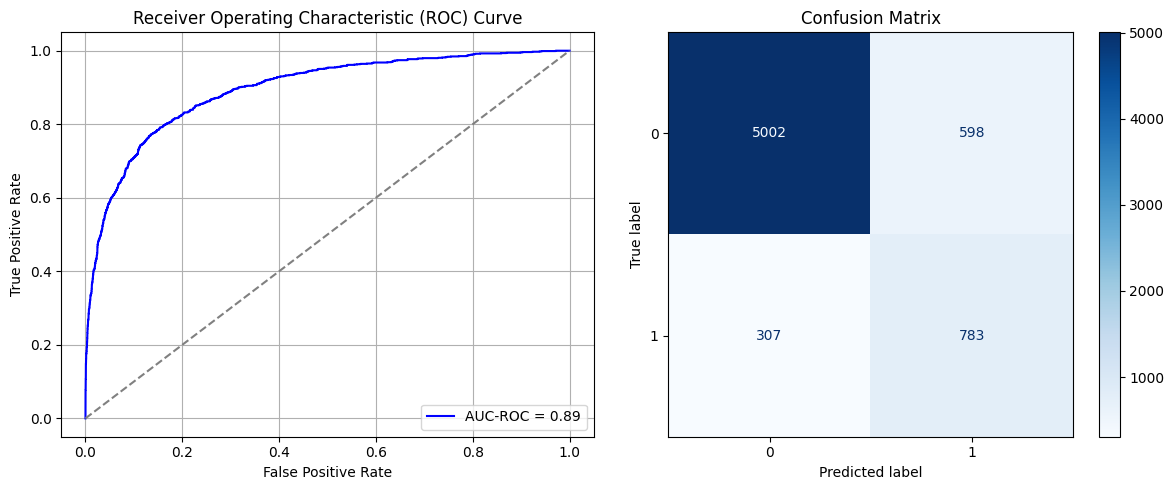

Best threshold based on F1-score: 0.5284052491188049
False Negative Rate: 0.281651376146789
Time elapsed (performance): 0.8289090880007279
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.5867 - loss: 0.6765 - val_AUC: 0.7545 - val_loss: 0.6059
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7558 - loss: 0.5962 - val_AUC: 0.8433 - val_loss: 0.5248
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8272 - loss: 0.5283 - val_AUC: 0.8810 - val_loss: 0.4735
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8529 - loss: 0.4860 - val_AUC: 0.8954 - val_loss: 0.4272
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8851 - loss: 0.4377 - val_AUC: 0.9070 - val_loss: 0.4116
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4241 - val_AUC: 0.9181 - val_loss: 0.3834
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9004 - loss: 0.4031 - val_AUC: 0.9272 - val_loss: 0.3571
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9121 - loss: 0.3819 - val_AUC: 0.9319 - val_loss: 0.3604
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9229 -

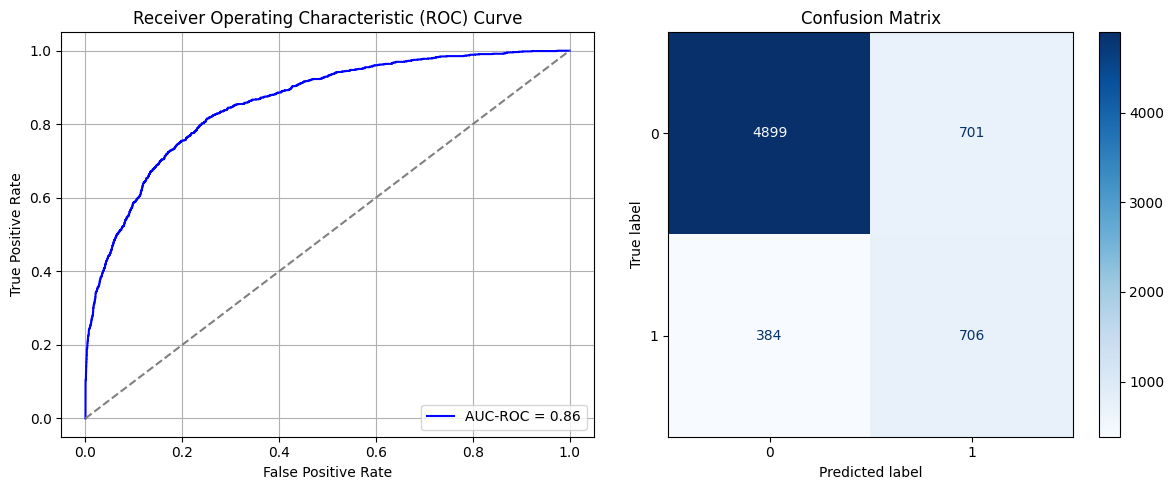

Best threshold based on F1-score: 0.47830837965011597
False Negative Rate: 0.3522935779816514
Time elapsed (performance): 1.210715474000608
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6055 - loss: 0.6728 - val_AUC: 0.7424 - val_loss: 0.6059
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7616 - loss: 0.5926 - val_AUC: 0.8248 - val_loss: 0.5360
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8278 - loss: 0.5246 - val_AUC: 0.8623 - val_loss: 0.4879
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8545 - loss: 0.4815 - val_AUC: 0.8825 - val_loss: 0.4433
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8690 - loss: 0.4530 - val_AUC: 0.8984 - val_loss: 0.4216
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8872 - loss: 0.4286 - val_AUC: 0.9004 - val_loss: 0.4086
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.4131 - val_AUC: 0.9070 - val_loss: 0.3971
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8994 - loss: 0.4042 - val_AUC: 0.9172 - val_loss: 0.3814
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8977 -

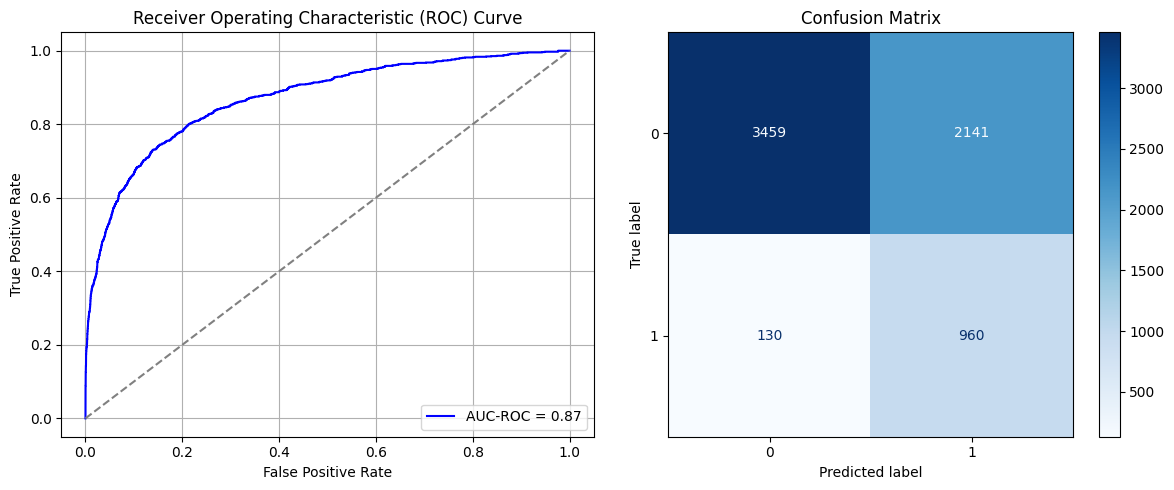

Best threshold based on F1-score: 0.8370417356491089
False Negative Rate: 0.11926605504587157
Time elapsed (performance): 0.8669555359992955
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6307 - loss: 0.6708 - val_AUC: 0.7677 - val_loss: 0.6107
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7640 - loss: 0.5933 - val_AUC: 0.8447 - val_loss: 0.5311
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8198 - loss: 0.5285 - val_AUC: 0.8760 - val_loss: 0.4777
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8518 - loss: 0.4862 - val_AUC: 0.8923 - val_loss: 0.4414
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8699 - loss: 0.4584 - val_AUC: 0.9037 - val_loss: 0.4155
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8851 - loss: 0.4322 - val_AUC: 0.9111 - val_loss: 0.4223
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4236 - val_AUC: 0.9215 - val_loss: 0.3828
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9057 - loss: 0.3948 - val_AUC: 0.9225 - val_loss: 0.3684
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9181 -

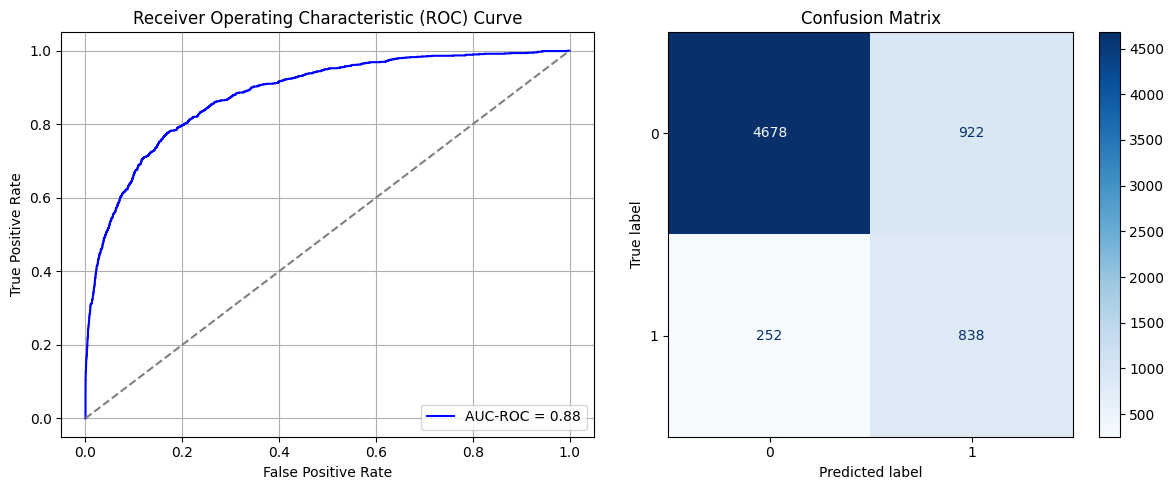

Best threshold based on F1-score: 0.6010944247245789
False Negative Rate: 0.23119266055045873
Time elapsed (performance): 0.8300173349998659
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.5944 - loss: 0.6779 - val_AUC: 0.7444 - val_loss: 0.6301
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7472 - loss: 0.6063 - val_AUC: 0.8016 - val_loss: 0.5616
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8009 - loss: 0.5533 - val_AUC: 0.8492 - val_loss: 0.5051
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8467 - loss: 0.5019 - val_AUC: 0.8734 - val_loss: 0.4580
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8690 - loss: 0.4624 - val_AUC: 0.8840 - val_loss: 0.4373
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8848 - loss: 0.4338 - val_AUC: 0.9050 - val_loss: 0.4108
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.4174 - val_AUC: 0.9109 - val_loss: 0.3960
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9070 - loss: 0.3928 - val_AUC: 0.9182 - val_loss: 0.3721
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9167 -

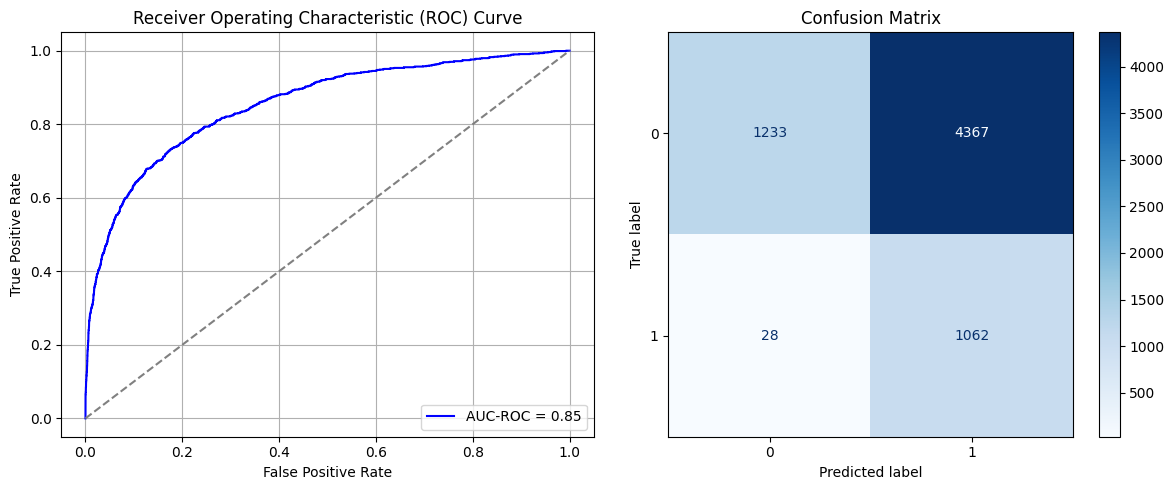

Best threshold based on F1-score: 0.9630478620529175
False Negative Rate: 0.025688073394495414
Time elapsed (performance): 0.8505434130001959
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6418 - loss: 0.6670 - val_AUC: 0.7451 - val_loss: 0.6071
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7485 - loss: 0.5994 - val_AUC: 0.8048 - val_loss: 0.5556
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8123 - loss: 0.5354 - val_AUC: 0.8440 - val_loss: 0.5298
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8479 - loss: 0.4963 - val_AUC: 0.8683 - val_loss: 0.4683
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8608 - loss: 0.4716 - val_AUC: 0.8808 - val_loss: 0.4533
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4448 - val_AUC: 0.8911 - val_loss: 0.4289
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8813 - loss: 0.4340 - val_AUC: 0.8982 - val_loss: 0.4210
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8997 - loss: 0.4035 - val_AUC: 0.9089 - val_loss: 0.4136
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9016 -

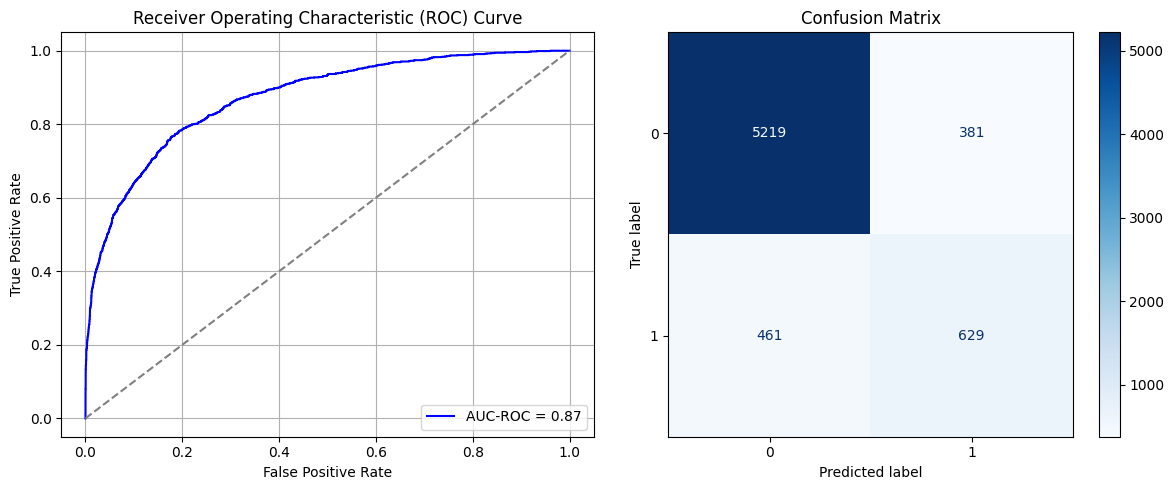

Best threshold based on F1-score: 0.5004794001579285
False Negative Rate: 0.42293577981651376
Time elapsed (performance): 1.6698610429994005
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6232 - loss: 0.6714 - val_AUC: 0.7583 - val_loss: 0.6035
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7561 - loss: 0.5956 - val_AUC: 0.8268 - val_loss: 0.5420
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8274 - loss: 0.5228 - val_AUC: 0.8612 - val_loss: 0.4838
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8602 - loss: 0.4746 - val_AUC: 0.8800 - val_loss: 0.4494
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8811 - loss: 0.4414 - val_AUC: 0.8872 - val_loss: 0.4422
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8913 - loss: 0.4236 - val_AUC: 0.8977 - val_loss: 0.4097
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8947 - loss: 0.4138 - val_AUC: 0.9066 - val_loss: 0.3978
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9085 - loss: 0.3873 - val_AUC: 0.9070 - val_loss: 0.3892
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9200 -

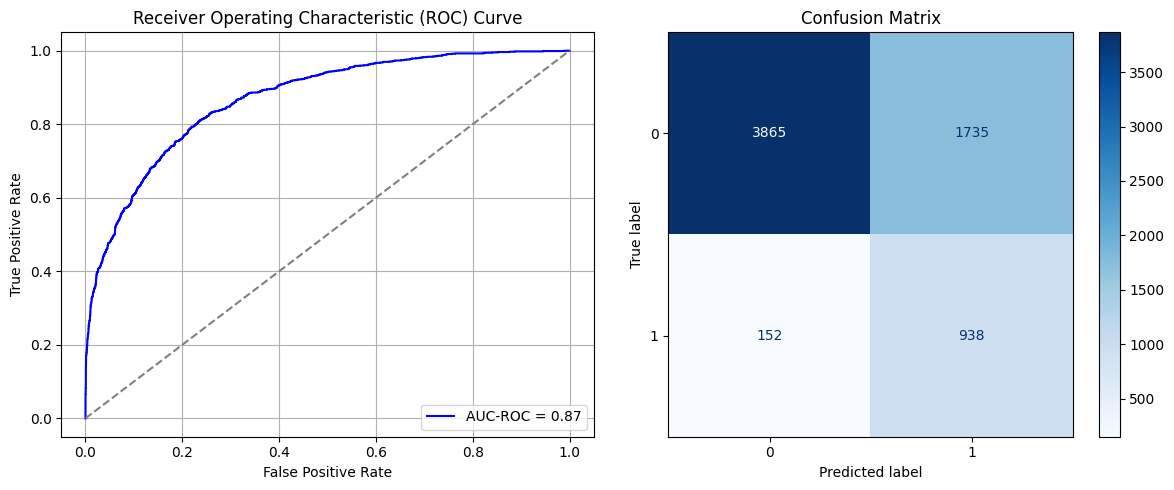

Best threshold based on F1-score: 0.8252171874046326
False Negative Rate: 0.13944954128440368
Time elapsed (performance): 0.908323104998999
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.6270 - loss: 0.6709 - val_AUC: 0.7574 - val_loss: 0.6005
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7761 - loss: 0.5782 - val_AUC: 0.8282 - val_loss: 0.5647
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8248 - loss: 0.5277 - val_AUC: 0.8676 - val_loss: 0.4796
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8618 - loss: 0.4765 - val_AUC: 0.8837 - val_loss: 0.4521
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8679 - loss: 0.4578 - val_AUC: 0.8983 - val_loss: 0.4350
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8864 - loss: 0.4283 - val_AUC: 0.9027 - val_loss: 0.4058
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8986 - loss: 0.4041 - val_AUC: 0.9107 - val_loss: 0.3893
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9144 - loss: 0.3748 - val_AUC: 0.9185 - val_loss: 0.3723
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9134 -

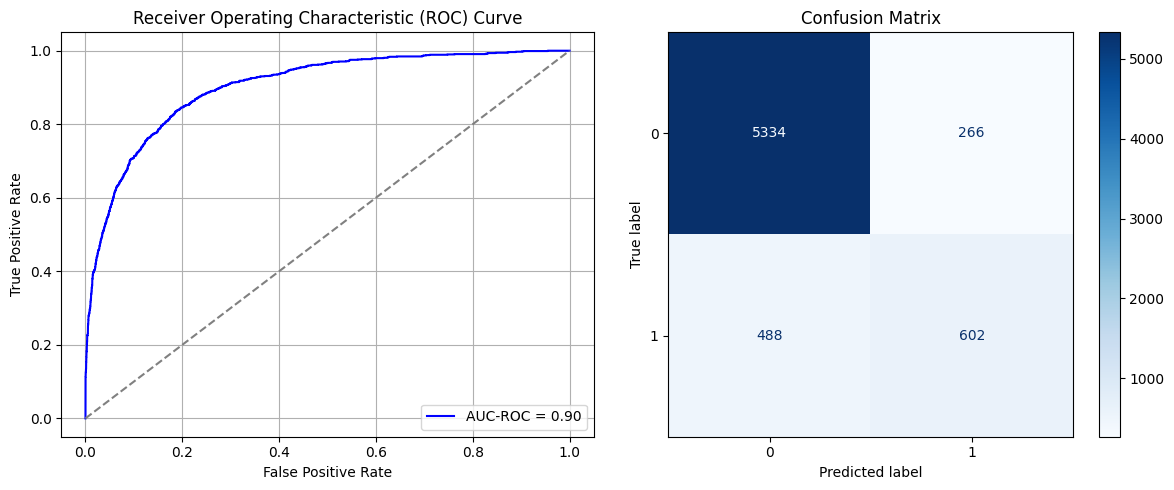

Best threshold based on F1-score: 0.3652764856815338
False Negative Rate: 0.44770642201834865
Time elapsed (performance): 1.7906867060009972
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6591 - loss: 0.6595 - val_AUC: 0.7563 - val_loss: 0.6038
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7537 - loss: 0.5983 - val_AUC: 0.8297 - val_loss: 0.5298
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8354 - loss: 0.5176 - val_AUC: 0.8647 - val_loss: 0.4924
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8581 - loss: 0.4786 - val_AUC: 0.8816 - val_loss: 0.4718
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8649 - loss: 0.4660 - val_AUC: 0.8948 - val_loss: 0.4491
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8867 - loss: 0.4308 - val_AUC: 0.9020 - val_loss: 0.4080
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9016 - loss: 0.4022 - val_AUC: 0.9102 - val_loss: 0.3912
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.9136 - loss: 0.3801 - val_AUC: 0.9178 - val_loss: 0.3762
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9147 -

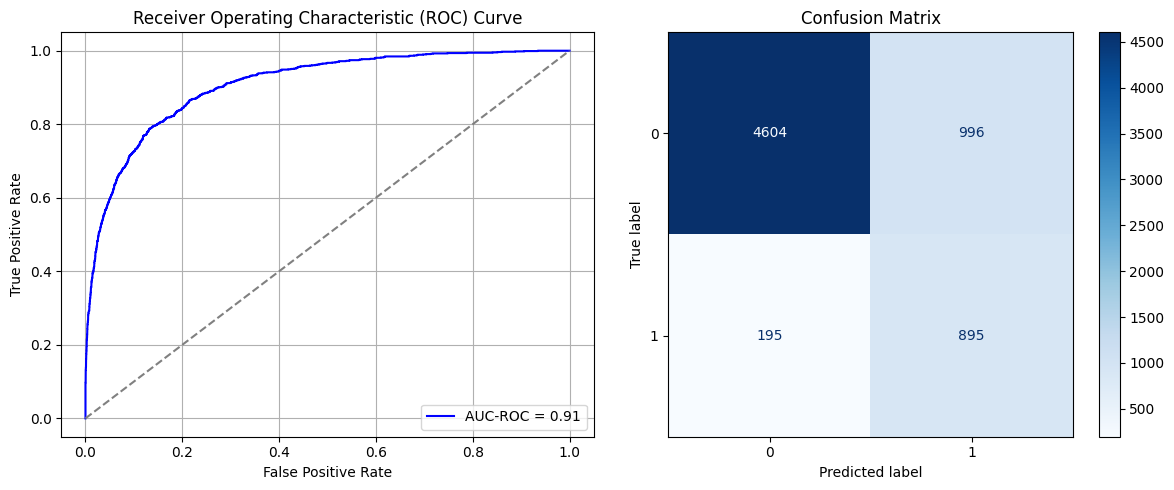

Best threshold based on F1-score: 0.690026581287384
False Negative Rate: 0.17889908256880735
Time elapsed (performance): 0.9195990790012729


In [44]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=True)
    data_S_SRSwR_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRSwR = data_S_SRSwR_RUS.iloc[:, :-1]
    y_S_SRSwR = data_S_SRSwR_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
    model_SRSwR = create_dnn_model(X_S_train.shape[1])
    result_SRSwR = train_and_evaluate(model_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRSwR = Transductive_TL(model_SRSwR, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRSwR)
    FPR.append(result_TL_SRSwR[0])
    TNR.append(result_TL_SRSwR[1])
    FNR.append(result_TL_SRSwR[2])
    TPR.append(result_TL_SRSwR[3])
    TL_time.append(result_TL_SRSwR[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [45]:
print('Mean:', ParamFit['FNR'].mean())
print('Variance:', ParamFit['FNR'].var())

Mean: 0.27339449541284405
Variance: 0.026796846505625225


In [46]:
print(ParamFit)
ParamFit.to_csv('SRSwR_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    10.094307  0.056250  0.943750  0.534862  0.465138     1.061011
1    10.245562  0.106786  0.893214  0.281651  0.718349     0.828909
2     8.497803  0.125179  0.874821  0.352294  0.647706     1.210715
3    10.885042  0.382321  0.617679  0.119266  0.880734     0.866956
4     9.532523  0.164643  0.835357  0.231193  0.768807     0.830017
5    12.069707  0.779821  0.220179  0.025688  0.974312     0.850543
6     9.351154  0.068036  0.931964  0.422936  0.577064     1.669861
7    13.639654  0.309821  0.690179  0.139450  0.860550     0.908323
8    15.286245  0.047500  0.952500  0.447706  0.552294     1.790687
9    12.990135  0.177857  0.822143  0.178899  0.821101     0.919599


## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

4.961636828644501
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.5833 - loss: 0.6773 - val_AUC: 0.7418 - val_loss: 0.6080
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7800 - loss: 0.5798 - val_AUC: 0.8110 - val_loss: 0.5568
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8294 - loss: 0.5205 - val_AUC: 0.8494 - val_loss: 0.4963
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8542 - loss: 0.4838 - val_AUC: 0.8711 - val_loss: 0.4788
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8686 - loss: 0.4577 - val_AUC: 0.8840 - val_loss: 0.4448
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8880 - loss: 0.4276 - val_AUC: 0.8891 - val_loss: 0.4264
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8784 - loss: 0.4388 - val_AUC: 0.9048 - val_loss: 0.4006
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9102 - loss: 0.3854 - val_AUC: 0.9148 - val_loss: 0.4227
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9060 -

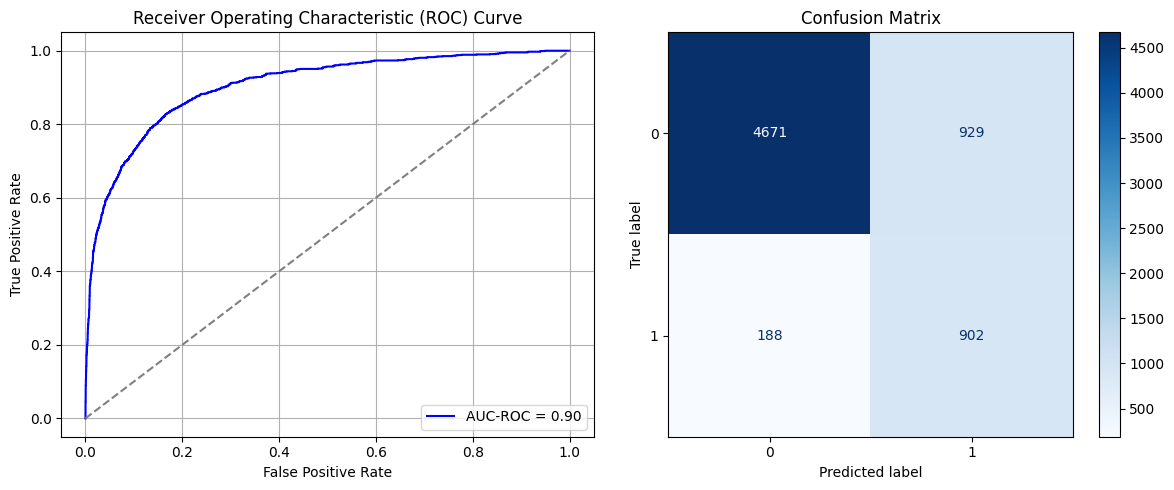

Best threshold based on F1-score: 0.648711085319519
False Negative Rate: 0.1724770642201835
Time elapsed (performance): 1.6735935420001624
(np.float64(0.16589285714285715), np.float64(0.8341071428571428))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6507 - loss: 0.6689 - val_AUC: 0.7521 - val_loss: 0.6091
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7530 - loss: 0.5969 - val_AUC: 0.8260 - val_loss: 0.5439
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8107 - loss: 0.5415 - val_AUC: 0.8664 - val_loss: 0.4914
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8378 - loss: 0.5030 - val_AUC: 0.8835 - val_loss: 0.4562
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8643 - loss: 0.4643 - val_AUC: 0.8950 - val_loss: 0.4225
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8810 - loss: 0.4360 - val_AUC: 0.9070 - val_loss: 0.4168
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8866 - loss: 0.4262 - val_AUC: 0.9130 - val_loss: 0.3827
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8990 - loss: 0.4041 - val_AUC: 0.9165 - val_loss: 0.3714
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9124 -

Best threshold based on F1-score: 0.7807393074035645
False Negative Rate: 0.12385321100917432
Time elapsed (performance): 0.9601845029992546
(np.float64(0.21446428571428572), np.float64(0.7855357142857142))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6531 - loss: 0.6611 - val_AUC: 0.7656 - val_loss: 0.6068
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7709 - loss: 0.5795 - val_AUC: 0.8418 - val_loss: 0.5161
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8357 - loss: 0.5129 - val_AUC: 0.8786 - val_loss: 0.4584
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8614 - loss: 0.4693 - val_AUC: 0.8925 - val_loss: 0.4279
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8978 - loss: 0.4132 - val_AUC: 0.9119 - val_loss: 0.3899
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9052 - loss: 0.3952 - val_AUC: 0.9210 - val_loss: 0.3700
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9244 - loss: 0.3604 - val_AUC: 0.9205 - val_loss: 0.3657
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9177 - loss: 0.3677 - val_AUC: 0.9319 - val_loss: 0.3475
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.9329 -

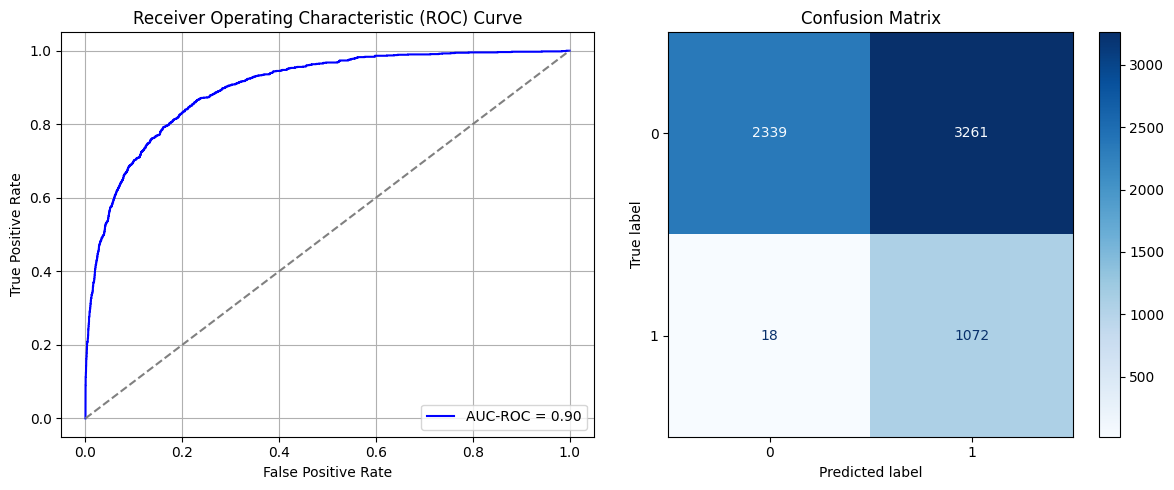

Best threshold based on F1-score: 0.9398152828216553
False Negative Rate: 0.01651376146788991
Time elapsed (performance): 0.8912543699989328
(np.float64(0.5823214285714285), np.float64(0.41767857142857145))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6328 - loss: 0.6713 - val_AUC: 0.7292 - val_loss: 0.6217
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7379 - loss: 0.6096 - val_AUC: 0.8150 - val_loss: 0.5451
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7984 - loss: 0.5516 - val_AUC: 0.8563 - val_loss: 0.5016
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8255 - loss: 0.5194 - val_AUC: 0.8788 - val_loss: 0.4628
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8483 - loss: 0.4869 - val_AUC: 0.8946 - val_loss: 0.4312
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8685 - loss: 0.4546 - val_AUC: 0.9058 - val_loss: 0.4162
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8795 - loss: 0.4372 - val_AUC: 0.9082 - val_loss: 0.4048
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8902 - loss: 0.4196 - val_AUC: 0.9192 - val_loss: 0.3785
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.8983 -

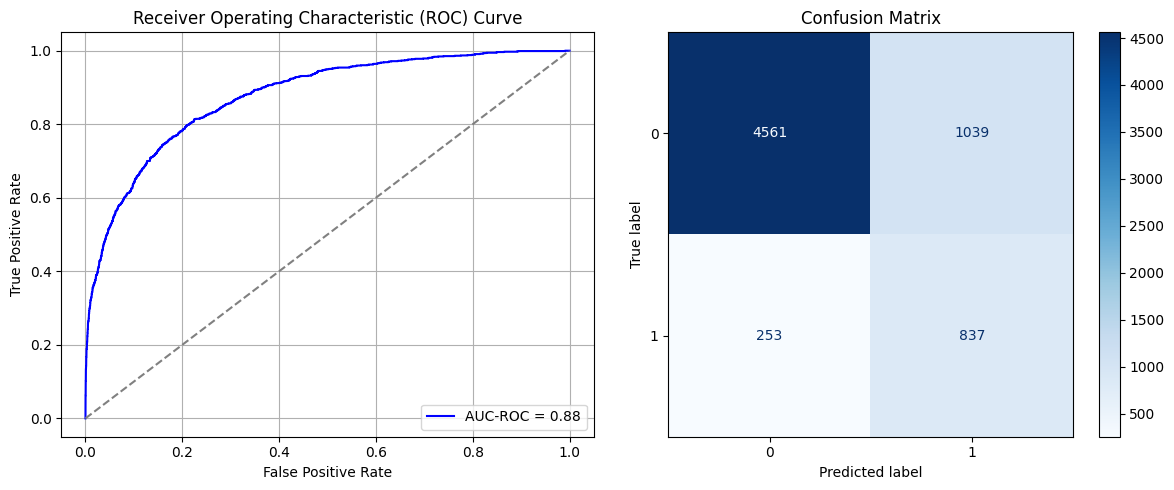

Best threshold based on F1-score: 0.730963408946991
False Negative Rate: 0.23211009174311928
Time elapsed (performance): 0.9417013120000775
(np.float64(0.18553571428571428), np.float64(0.8144642857142858))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6568 - loss: 0.6593 - val_AUC: 0.7918 - val_loss: 0.5851
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7746 - loss: 0.5820 - val_AUC: 0.8417 - val_loss: 0.5357
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8244 - loss: 0.5243 - val_AUC: 0.8796 - val_loss: 0.4721
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8571 - loss: 0.4811 - val_AUC: 0.8986 - val_loss: 0.4282
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8803 - loss: 0.4450 - val_AUC: 0.9076 - val_loss: 0.4012
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8926 - loss: 0.4180 - val_AUC: 0.9110 - val_loss: 0.3888
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9174 - loss: 0.3748 - val_AUC: 0.9256 - val_loss: 0.3627
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9245 - loss: 0.3602 - val_AUC: 0.9352 - val_loss: 0.3412
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9310 -

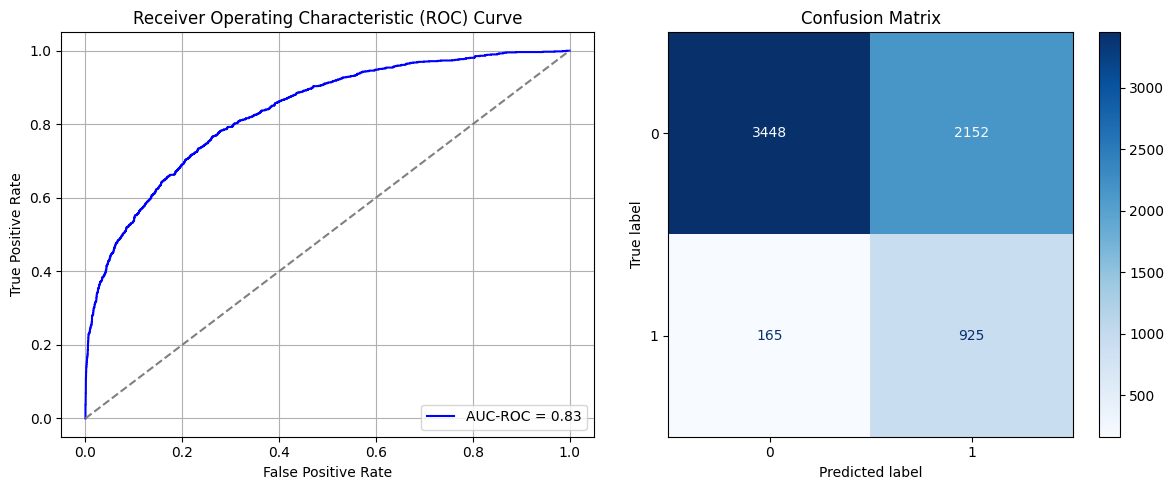

Best threshold based on F1-score: 0.8588383197784424
False Negative Rate: 0.15137614678899083
Time elapsed (performance): 1.0826428840009612
(np.float64(0.3842857142857143), np.float64(0.6157142857142857))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6393 - loss: 0.6682 - val_AUC: 0.7583 - val_loss: 0.6033
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7662 - loss: 0.5889 - val_AUC: 0.8277 - val_loss: 0.5312
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8078 - loss: 0.5405 - val_AUC: 0.8539 - val_loss: 0.4939
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8330 - loss: 0.5087 - val_AUC: 0.8686 - val_loss: 0.4670
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8597 - loss: 0.4739 - val_AUC: 0.8831 - val_loss: 0.4395
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8709 - loss: 0.4500 - val_AUC: 0.8887 - val_loss: 0.4268
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8943 - loss: 0.4149 - val_AUC: 0.9020 - val_loss: 0.4187
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8966 - loss: 0.4093 - val_AUC: 0.9072 - val_loss: 0.3967
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9024 -

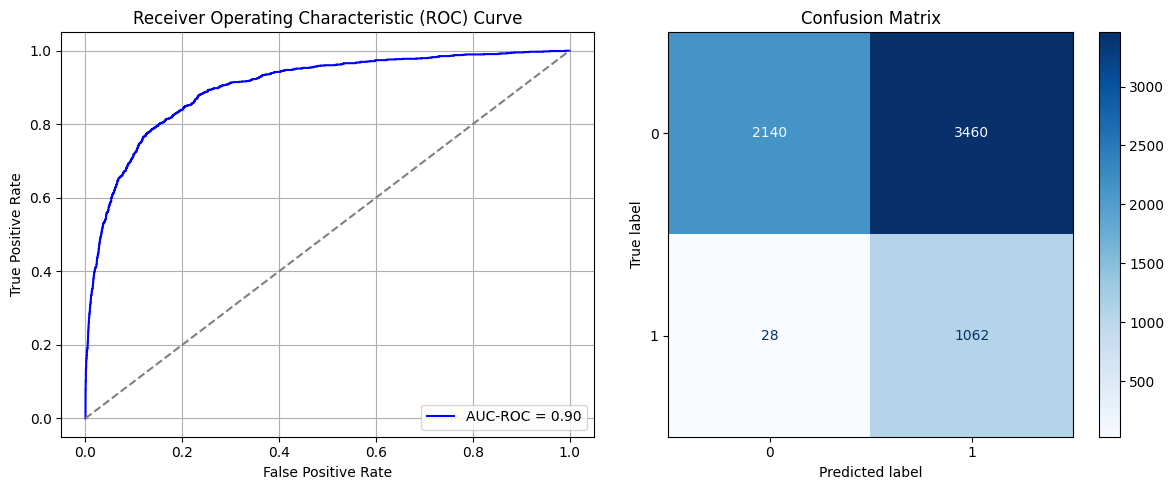

Best threshold based on F1-score: 0.9126619100570679
False Negative Rate: 0.025688073394495414
Time elapsed (performance): 0.9163923369997065
(np.float64(0.6178571428571429), np.float64(0.3821428571428571))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.6107 - loss: 0.6747 - val_AUC: 0.7338 - val_loss: 0.6117
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7435 - loss: 0.6018 - val_AUC: 0.8060 - val_loss: 0.5547
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8135 - loss: 0.5395 - val_AUC: 0.8553 - val_loss: 0.5129
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8603 - loss: 0.4806 - val_AUC: 0.8885 - val_loss: 0.4493
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8814 - loss: 0.4462 - val_AUC: 0.8926 - val_loss: 0.4584
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8895 - loss: 0.4271 - val_AUC: 0.9129 - val_loss: 0.3978
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9128 - loss: 0.3881 - val_AUC: 0.9185 - val_loss: 0.4005
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9211 - loss: 0.3684 - val_AUC: 0.9249 - val_loss: 0.3632
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9295 -

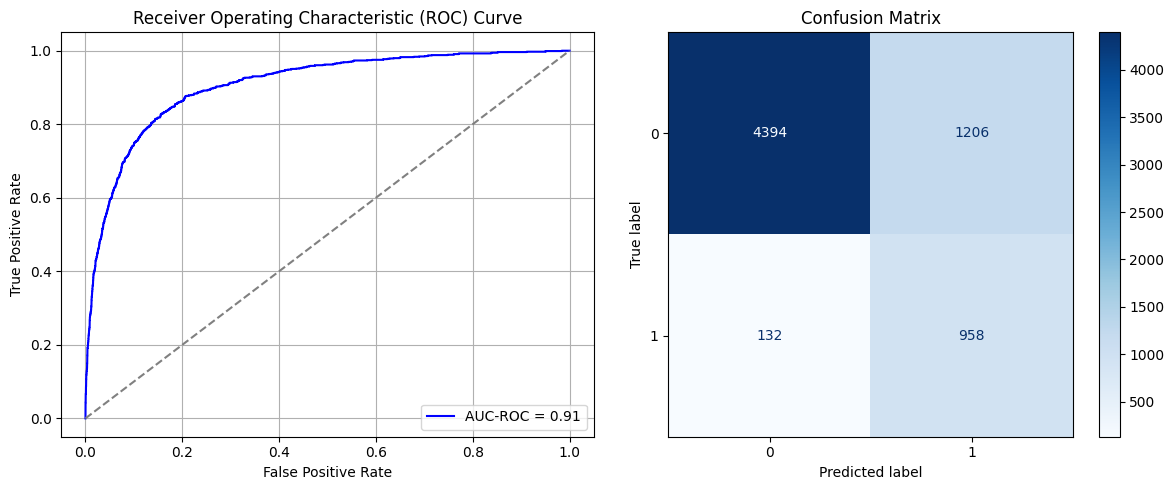

Best threshold based on F1-score: 0.7139295935630798
False Negative Rate: 0.12110091743119267
Time elapsed (performance): 0.9162221839997073
(np.float64(0.21535714285714286), np.float64(0.7846428571428572))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6277 - loss: 0.6684 - val_AUC: 0.7776 - val_loss: 0.5890
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7659 - loss: 0.5860 - val_AUC: 0.8367 - val_loss: 0.5577
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8136 - loss: 0.5344 - val_AUC: 0.8761 - val_loss: 0.4727
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8407 - loss: 0.4993 - val_AUC: 0.8958 - val_loss: 0.4386
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8681 - loss: 0.4600 - val_AUC: 0.9085 - val_loss: 0.4126
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8828 - loss: 0.4362 - val_AUC: 0.9199 - val_loss: 0.3880
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8968 - loss: 0.4126 - val_AUC: 0.9276 - val_loss: 0.3931
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9019 - loss: 0.4009 - val_AUC: 0.9348 - val_loss: 0.3461
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9151 -

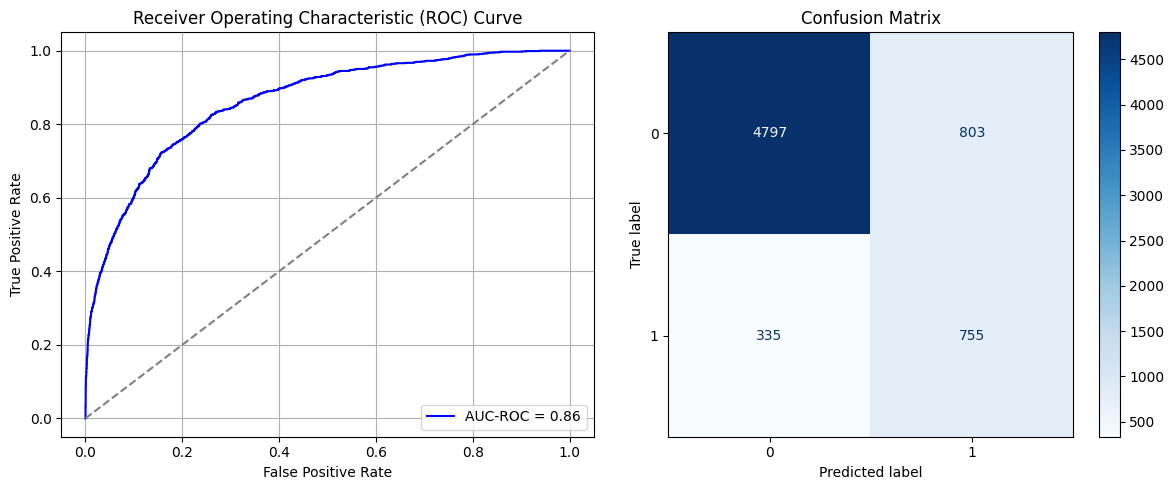

Best threshold based on F1-score: 0.5758776664733887
False Negative Rate: 0.3073394495412844
Time elapsed (performance): 1.1291763160006667
(np.float64(0.14339285714285716), np.float64(0.8566071428571429))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6686 - loss: 0.6573 - val_AUC: 0.7828 - val_loss: 0.5953
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8018 - loss: 0.5582 - val_AUC: 0.8374 - val_loss: 0.5478
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8343 - loss: 0.5142 - val_AUC: 0.8671 - val_loss: 0.4745
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8796 - loss: 0.4482 - val_AUC: 0.8820 - val_loss: 0.4552
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8739 - loss: 0.4492 - val_AUC: 0.8945 - val_loss: 0.4223
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8990 - loss: 0.4075 - val_AUC: 0.9025 - val_loss: 0.4034
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9030 - loss: 0.3971 - val_AUC: 0.9176 - val_loss: 0.3822
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9181 - loss: 0.3686 - val_AUC: 0.9282 - val_loss: 0.3603
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9253 -

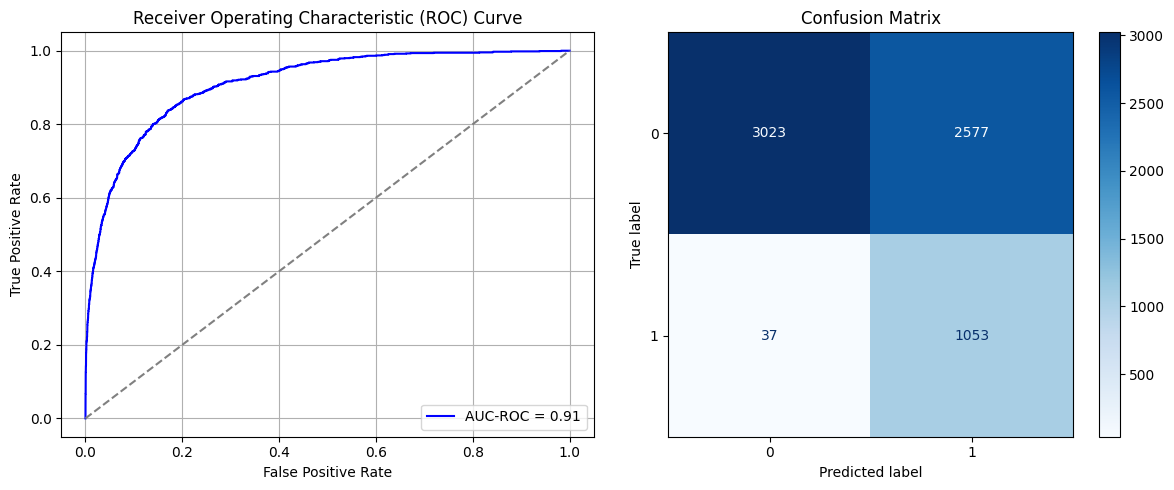

Best threshold based on F1-score: 0.8878515958786011
False Negative Rate: 0.03394495412844037
Time elapsed (performance): 0.8461496290001378
(np.float64(0.46017857142857144), np.float64(0.5398214285714286))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6431 - loss: 0.6692 - val_AUC: 0.7581 - val_loss: 0.6011
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7686 - loss: 0.5853 - val_AUC: 0.8449 - val_loss: 0.5353
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8276 - loss: 0.5289 - val_AUC: 0.8757 - val_loss: 0.4851
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8457 - loss: 0.4978 - val_AUC: 0.8844 - val_loss: 0.4555
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8757 - loss: 0.4509 - val_AUC: 0.9036 - val_loss: 0.4263
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8877 - loss: 0.4278 - val_AUC: 0.9135 - val_loss: 0.3977
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8999 - loss: 0.4076 - val_AUC: 0.9220 - val_loss: 0.3860
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9048 - loss: 0.3966 - val_AUC: 0.9277 - val_loss: 0.3818
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9105 -

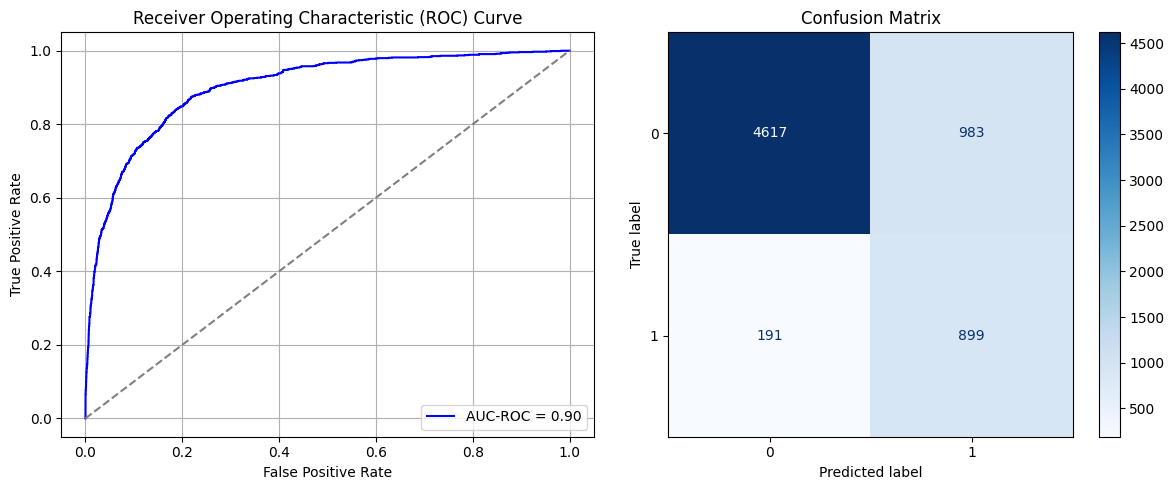

Best threshold based on F1-score: 0.6610787510871887
False Negative Rate: 0.17522935779816515
Time elapsed (performance): 1.1114393939988076
(np.float64(0.1755357142857143), np.float64(0.8244642857142856))
   Source time       FPR       TNR       FNR       TPR  Target time
0    14.642718  0.165893  0.834107  0.172477  0.827523     1.673594
1    12.658625  0.214464  0.785536  0.123853  0.876147     0.960185
2    12.203258  0.582321  0.417679  0.016514  0.983486     0.891254
3    11.735589  0.185536  0.814464  0.232110  0.767890     0.941701
4    13.088399  0.384286  0.615714  0.151376  0.848624     1.082643
5    11.722516  0.617857  0.382143  0.025688  0.974312     0.916392
6    13.431319  0.215357  0.784643  0.121101  0.878899     0.916222
7    12.237529  0.143393  0.856607  0.307339  0.692661     1.129176
8    12.485137  0.460179  0.539821  0.033945  0.966055     0.846150
9    10.989219  0.175536  0.824464  0.175229  0.824771     1.111439


In [47]:
import random

times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = oversample_size/undersample_size
print(k)

# np.random.seed(123)

for i in range(times):
    start = random.randint(1, int(k))
    # print(start)

    Row = []

    for j in range(undersample_size):
      row = start+int(k*j)-1
      Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :-1]
    y_S_Sy = data_S_Sy_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)


In [48]:
print('Mean:', ParamFit['FNR'].mean())
print('Variance:', ParamFit['FNR'].var())

Mean: 0.1359633027522936
Variance: 0.00877008108183935


In [49]:
print(ParamFit)
ParamFit.to_csv('Sy_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    14.642718  0.165893  0.834107  0.172477  0.827523     1.673594
1    12.658625  0.214464  0.785536  0.123853  0.876147     0.960185
2    12.203258  0.582321  0.417679  0.016514  0.983486     0.891254
3    11.735589  0.185536  0.814464  0.232110  0.767890     0.941701
4    13.088399  0.384286  0.615714  0.151376  0.848624     1.082643
5    11.722516  0.617857  0.382143  0.025688  0.974312     0.916392
6    13.431319  0.215357  0.784643  0.121101  0.878899     0.916222
7    12.237529  0.143393  0.856607  0.307339  0.692661     1.129176
8    12.485137  0.460179  0.539821  0.033945  0.966055     0.846150
9    10.989219  0.175536  0.824464  0.175229  0.824771     1.111439


## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

49.61636828644501
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6361 - loss: 0.6694 - val_AUC: 0.7722 - val_loss: 0.5925
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7723 - loss: 0.5842 - val_AUC: 0.8392 - val_loss: 0.5232
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8228 - loss: 0.5294 - val_AUC: 0.8673 - val_loss: 0.4819
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8566 - loss: 0.4837 - val_AUC: 0.8774 - val_loss: 0.4547
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8668 - loss: 0.4603 - val_AUC: 0.8876 - val_loss: 0.4374
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4377 - val_AUC: 0.9020 - val_loss: 0.4060
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8909 - loss: 0.4190 - val_AUC: 0.9114 - val_loss: 0.3889
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9007 - loss: 0.4029 - val_AUC: 0.9161 - val_loss: 0.3742
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9165 -

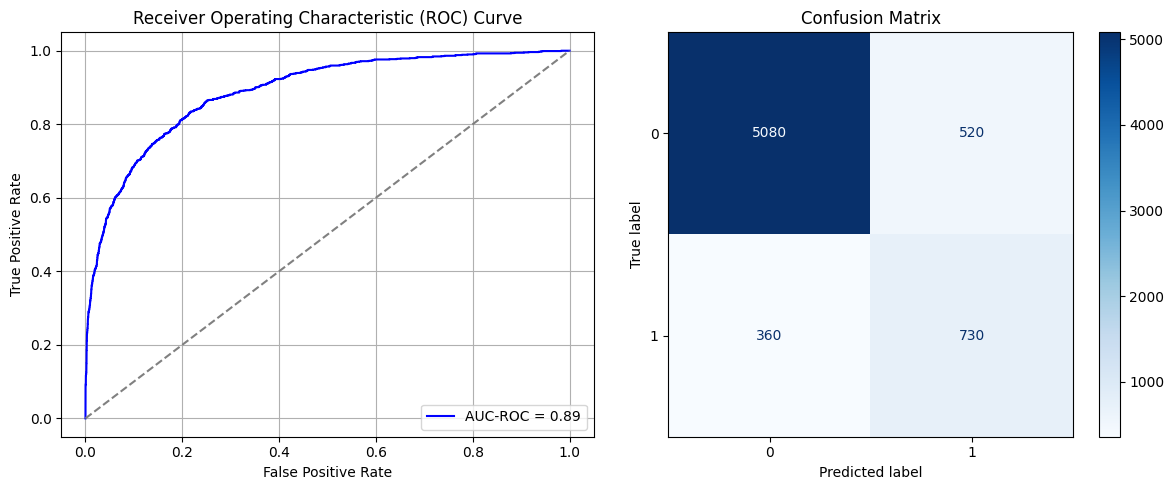

Best threshold based on F1-score: 0.5777638554573059
False Negative Rate: 0.3302752293577982
Time elapsed (performance): 1.048178648999965
(np.float64(0.09285714285714286), np.float64(0.9071428571428571))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.6470 - loss: 0.6690 - val_AUC: 0.7640 - val_loss: 0.6048
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7505 - loss: 0.6016 - val_AUC: 0.8181 - val_loss: 0.5478
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8027 - loss: 0.5528 - val_AUC: 0.8568 - val_loss: 0.5113
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8398 - loss: 0.5069 - val_AUC: 0.8780 - val_loss: 0.4564
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8613 - loss: 0.4722 - val_AUC: 0.8915 - val_loss: 0.4289
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8765 - loss: 0.4448 - val_AUC: 0.9004 - val_loss: 0.4122
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8945 - loss: 0.4158 - val_AUC: 0.9122 - val_loss: 0.3871
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9063 - loss: 0.3931 - val_AUC: 0.9230 - val_loss: 0.3644
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9118 -

Best threshold based on F1-score: 0.7517261505126953
False Negative Rate: 0.16238532110091744
Time elapsed (performance): 0.8500093829989055
(np.float64(0.2742857142857143), np.float64(0.7257142857142858))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6429 - loss: 0.6650 - val_AUC: 0.7458 - val_loss: 0.6101
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7636 - loss: 0.5886 - val_AUC: 0.8163 - val_loss: 0.5390
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8265 - loss: 0.5254 - val_AUC: 0.8487 - val_loss: 0.4974
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8450 - loss: 0.4939 - val_AUC: 0.8706 - val_loss: 0.4616
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8733 - loss: 0.4546 - val_AUC: 0.8847 - val_loss: 0.4343
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8811 - loss: 0.4379 - val_AUC: 0.8913 - val_loss: 0.4293
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4297 - val_AUC: 0.9020 - val_loss: 0.4079
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9016 - loss: 0.4014 - val_AUC: 0.9100 - val_loss: 0.3885
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9052 -

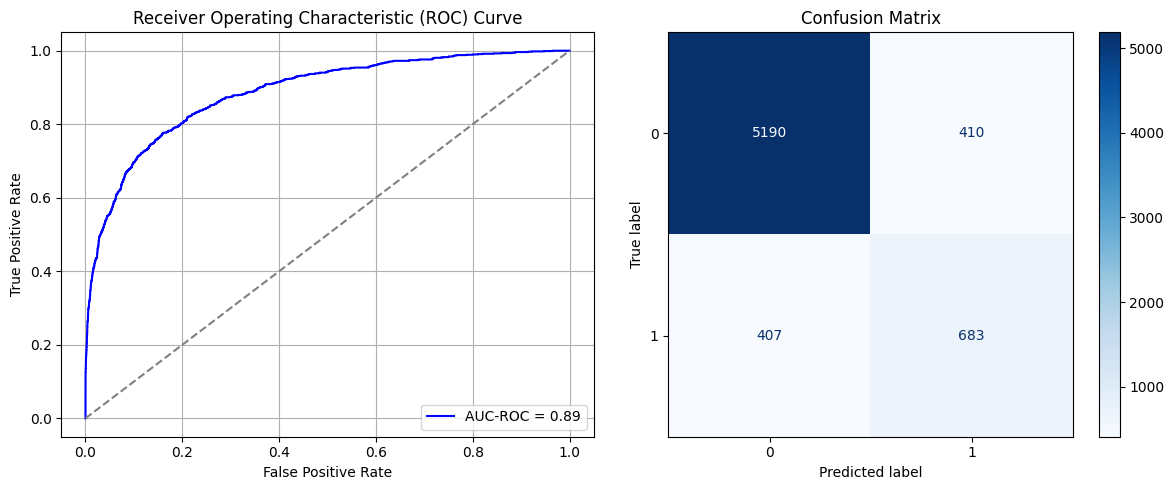

Best threshold based on F1-score: 0.4666725993156433
False Negative Rate: 0.37339449541284403
Time elapsed (performance): 1.0923757340005977
(np.float64(0.07321428571428572), np.float64(0.9267857142857143))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6427 - loss: 0.6668 - val_AUC: 0.7803 - val_loss: 0.5898
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7767 - loss: 0.5801 - val_AUC: 0.8328 - val_loss: 0.5218
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8230 - loss: 0.5196 - val_AUC: 0.8763 - val_loss: 0.4812
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8576 - loss: 0.4764 - val_AUC: 0.8941 - val_loss: 0.4279
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8797 - loss: 0.4419 - val_AUC: 0.9133 - val_loss: 0.4034
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8914 - loss: 0.4184 - val_AUC: 0.9206 - val_loss: 0.3810
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9101 - loss: 0.3861 - val_AUC: 0.9283 - val_loss: 0.3886
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9191 - loss: 0.3706 - val_AUC: 0.9377 - val_loss: 0.3371
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9175 -

Best threshold based on F1-score: 0.8255603909492493
False Negative Rate: 0.08256880733944955
Time elapsed (performance): 0.8660229719989729
(np.float64(0.37357142857142855), np.float64(0.6264285714285714))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6331 - loss: 0.6681 - val_AUC: 0.7608 - val_loss: 0.5986
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7642 - loss: 0.5899 - val_AUC: 0.8311 - val_loss: 0.5362
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8312 - loss: 0.5251 - val_AUC: 0.8594 - val_loss: 0.4880
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8565 - loss: 0.4807 - val_AUC: 0.8754 - val_loss: 0.4498
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8757 - loss: 0.4467 - val_AUC: 0.8915 - val_loss: 0.4306
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8784 - loss: 0.4418 - val_AUC: 0.8975 - val_loss: 0.4681
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8942 - loss: 0.4159 - val_AUC: 0.9043 - val_loss: 0.4000
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9119 - loss: 0.3823 - val_AUC: 0.9127 - val_loss: 0.3799
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9253 -

Best threshold based on F1-score: 0.7944803237915039
False Negative Rate: 0.14220183486238533
Time elapsed (performance): 1.1139900510006555
(np.float64(0.3242857142857143), np.float64(0.6757142857142857))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6274 - loss: 0.6713 - val_AUC: 0.7810 - val_loss: 0.5948
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7789 - loss: 0.5840 - val_AUC: 0.8426 - val_loss: 0.5288
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8309 - loss: 0.5201 - val_AUC: 0.8658 - val_loss: 0.4805
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8721 - loss: 0.4607 - val_AUC: 0.8731 - val_loss: 0.4828
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8713 - loss: 0.4540 - val_AUC: 0.8915 - val_loss: 0.4296
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8932 - loss: 0.4197 - val_AUC: 0.8982 - val_loss: 0.4155
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8987 - loss: 0.4065 - val_AUC: 0.9098 - val_loss: 0.3906
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9078 - loss: 0.3912 - val_AUC: 0.9129 - val_loss: 0.3911
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9109 -

Best threshold based on F1-score: 0.44679468870162964
False Negative Rate: 0.43761467889908257
Time elapsed (performance): 0.7808892840002954
(np.float64(0.09732142857142857), np.float64(0.9026785714285714))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5926 - loss: 0.6741 - val_AUC: 0.7562 - val_loss: 0.5994
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7566 - loss: 0.5919 - val_AUC: 0.8219 - val_loss: 0.5462
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8098 - loss: 0.5420 - val_AUC: 0.8553 - val_loss: 0.4915
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8332 - loss: 0.5089 - val_AUC: 0.8730 - val_loss: 0.4571
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8659 - loss: 0.4639 - val_AUC: 0.8850 - val_loss: 0.4360
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8724 - loss: 0.4493 - val_AUC: 0.8987 - val_loss: 0.4259
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8802 - loss: 0.4365 - val_AUC: 0.9039 - val_loss: 0.4014
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8969 - loss: 0.4073 - val_AUC: 0.9141 - val_loss: 0.3866
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9057 -

Best threshold based on F1-score: 0.9112069010734558
False Negative Rate: 0.04128440366972477
Time elapsed (performance): 0.7919630409996898
(np.float64(0.5778571428571428), np.float64(0.42214285714285715))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.6381 - loss: 0.6670 - val_AUC: 0.7692 - val_loss: 0.5978
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7559 - loss: 0.5974 - val_AUC: 0.8247 - val_loss: 0.5928
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8119 - loss: 0.5376 - val_AUC: 0.8601 - val_loss: 0.4902
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8530 - loss: 0.4893 - val_AUC: 0.8839 - val_loss: 0.4498
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8735 - loss: 0.4554 - val_AUC: 0.9002 - val_loss: 0.4147
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4276 - val_AUC: 0.9068 - val_loss: 0.3981
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8945 - loss: 0.4158 - val_AUC: 0.9187 - val_loss: 0.3736
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9116 - loss: 0.3822 - val_AUC: 0.9217 - val_loss: 0.3639
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.9189 -

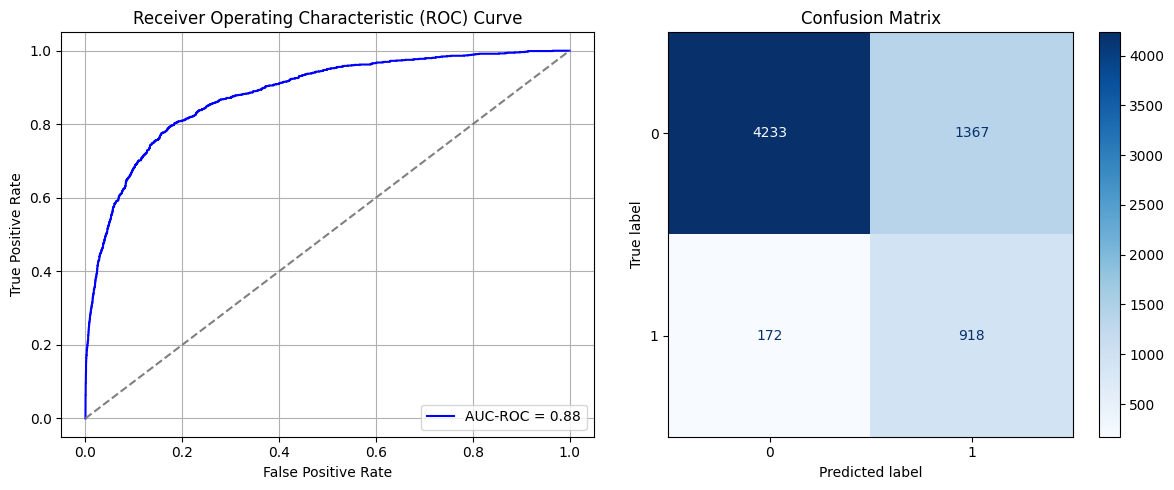

Best threshold based on F1-score: 0.7619789838790894
False Negative Rate: 0.1577981651376147
Time elapsed (performance): 1.0765542350000032
(np.float64(0.24410714285714286), np.float64(0.7558928571428571))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6139 - loss: 0.6725 - val_AUC: 0.7291 - val_loss: 0.6221
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7420 - loss: 0.6083 - val_AUC: 0.8157 - val_loss: 0.5546
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8271 - loss: 0.5306 - val_AUC: 0.8523 - val_loss: 0.4921
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8658 - loss: 0.4699 - val_AUC: 0.8711 - val_loss: 0.4794
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8771 - loss: 0.4460 - val_AUC: 0.8817 - val_loss: 0.4418
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8855 - loss: 0.4311 - val_AUC: 0.8862 - val_loss: 0.4296
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8967 - loss: 0.4134 - val_AUC: 0.8967 - val_loss: 0.4127
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9019 - loss: 0.4033 - val_AUC: 0.9110 - val_loss: 0.3867
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9115 -

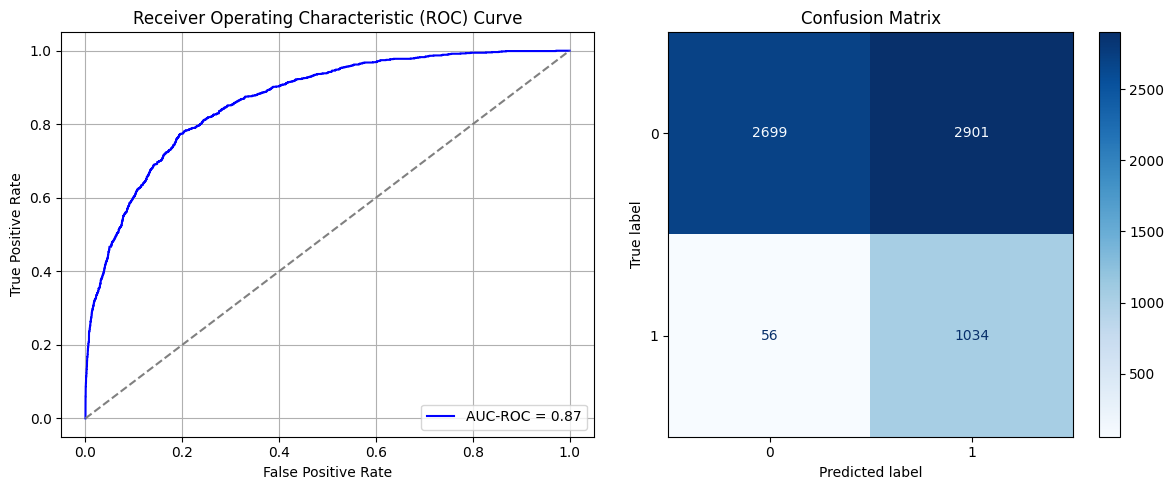

Best threshold based on F1-score: 0.8602429032325745
False Negative Rate: 0.05137614678899083
Time elapsed (performance): 0.8414092120001442
(np.float64(0.5180357142857143), np.float64(0.48196428571428573))
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.5942 - loss: 0.6776 - val_AUC: 0.7536 - val_loss: 0.6060
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7666 - loss: 0.5892 - val_AUC: 0.8351 - val_loss: 0.5331
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8369 - loss: 0.5149 - val_AUC: 0.8801 - val_loss: 0.4640
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8678 - loss: 0.4675 - val_AUC: 0.9007 - val_loss: 0.4505
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8830 - loss: 0.4387 - val_AUC: 0.9077 - val_loss: 0.3996
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8967 - loss: 0.4104 - val_AUC: 0.9232 - val_loss: 0.3684
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9111 - loss: 0.3823 - val_AUC: 0.9273 - val_loss: 0.3557
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9192 - loss: 0.3660 - val_AUC: 0.9332 - val_loss: 0.3424
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9272 -

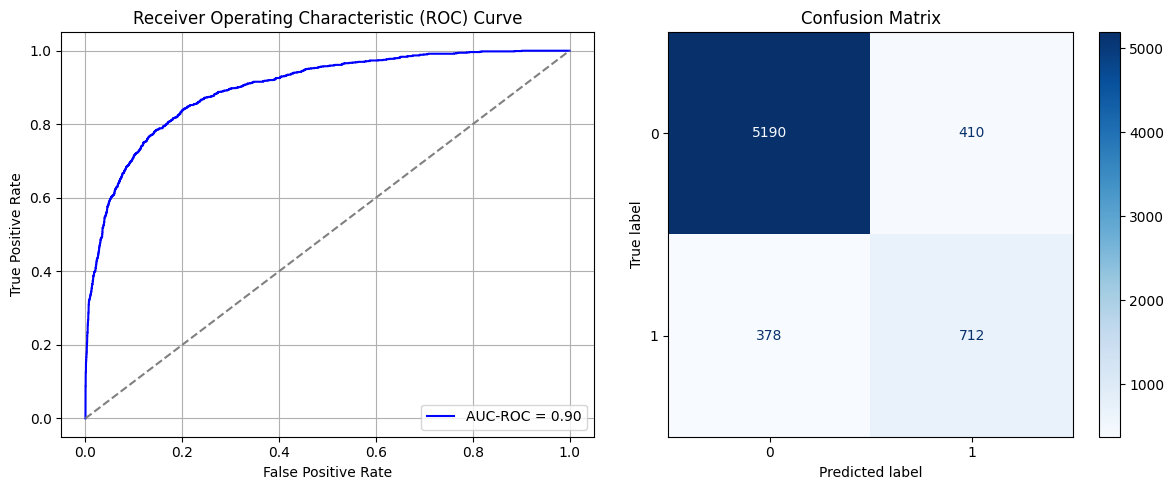

Best threshold based on F1-score: 0.4852587878704071
False Negative Rate: 0.3467889908256881
Time elapsed (performance): 1.0905770339995797
(np.float64(0.07321428571428572), np.float64(0.9267857142857143))
   Source time       FPR       TNR       FNR       TPR  Target time
0     9.245397  0.092857  0.907143  0.330275  0.669725     1.048179
1    10.963528  0.274286  0.725714  0.162385  0.837615     0.850009
2    10.108448  0.073214  0.926786  0.373394  0.626606     1.092376
3    10.763825  0.373571  0.626429  0.082569  0.917431     0.866023
4    10.800130  0.324286  0.675714  0.142202  0.857798     1.113990
5    10.157518  0.097321  0.902679  0.437615  0.562385     0.780889
6     9.590938  0.577857  0.422143  0.041284  0.958716     0.791963
7    11.135051  0.244107  0.755893  0.157798  0.842202     1.076554
8    12.705791  0.518036  0.481964  0.051376  0.948624     0.841409
9    12.298086  0.073214  0.926786  0.346789  0.653211     1.090577


In [50]:
import random

times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

m = 10

k = oversample_size/undersample_size * m
print(k)

# np.random.seed(123)

for i in range(times):
    start = np.random.choice(int(k), 10)
    # print(start)

    Row = []

    Row = []

    for j in range(len(start)):
      for l in range(int(undersample_size/m)):
        row = start[j]+int(k*l)-1
        Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :-1]
    y_S_Sy = data_S_Sy_RUS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)

In [51]:
print('Mean:', ParamFit['FNR'].mean())
print('Variance:', ParamFit['FNR'].var())

Mean: 0.21256880733944955
Variance: 0.021230171422158627


In [52]:
print(ParamFit)
ParamFit.to_csv('Sy2_RUS.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0     9.245397  0.092857  0.907143  0.330275  0.669725     1.048179
1    10.963528  0.274286  0.725714  0.162385  0.837615     0.850009
2    10.108448  0.073214  0.926786  0.373394  0.626606     1.092376
3    10.763825  0.373571  0.626429  0.082569  0.917431     0.866023
4    10.800130  0.324286  0.675714  0.142202  0.857798     1.113990
5    10.157518  0.097321  0.902679  0.437615  0.562385     0.780889
6     9.590938  0.577857  0.422143  0.041284  0.958716     0.791963
7    11.135051  0.244107  0.755893  0.157798  0.842202     1.076554
8    12.705791  0.518036  0.481964  0.051376  0.948624     0.841409
9    12.298086  0.073214  0.926786  0.346789  0.653211     1.090577


# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [53]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

3910
19400


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7464 - loss: 0.5949 - val_AUC: 0.8890 - val_loss: 0.4295
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8918 - loss: 0.4195 - val_AUC: 0.9277 - val_loss: 0.3503
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9289 - loss: 0.3446 - val_AUC: 0.9488 - val_loss: 0.2947
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9472 - loss: 0.2977 - val_AUC: 0.9604 - val_loss: 0.2622
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9558 - loss: 0.2722 - val_AUC: 0.9642 - val_loss: 0.2644
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9603 - loss: 0.2576 - val_AUC: 0.9678 - val_loss: 0.2317
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9644 - loss: 0.2440 - val_AUC: 0.9719 - val_loss: 0.2374
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9671 - loss: 0.2332 - val_AUC: 0.9736 - val_loss: 0.2101
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9673 -

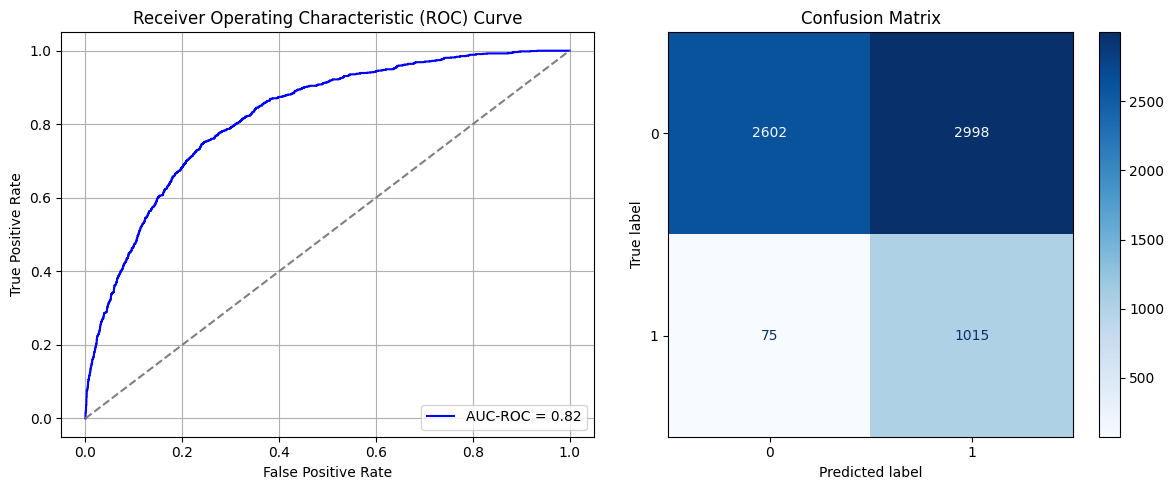

Best threshold based on F1-score: 0.971923291683197
False Negative Rate: 0.06880733944954129
Time elapsed (performance): 0.920509151999795
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7380 - loss: 0.6027 - val_AUC: 0.8720 - val_loss: 0.4568
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8685 - loss: 0.4553 - val_AUC: 0.9055 - val_loss: 0.3918
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9114 - loss: 0.3804 - val_AUC: 0.9325 - val_loss: 0.3534
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9354 - loss: 0.3290 - val_AUC: 0.9470 - val_loss: 0.3008
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9487 - loss: 0.2931 - val_AUC: 0.9580 - val_loss: 0.2689
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9580 - loss: 0.2659 - val_AUC: 0.9640 - val_loss: 0.2669
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9620 - loss: 0.2517 - val_AUC: 0.9677 - val_loss: 0.2628
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9663 - loss: 0.2356 - val_AUC: 0.9723 - val_loss: 0.2136
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9723 -

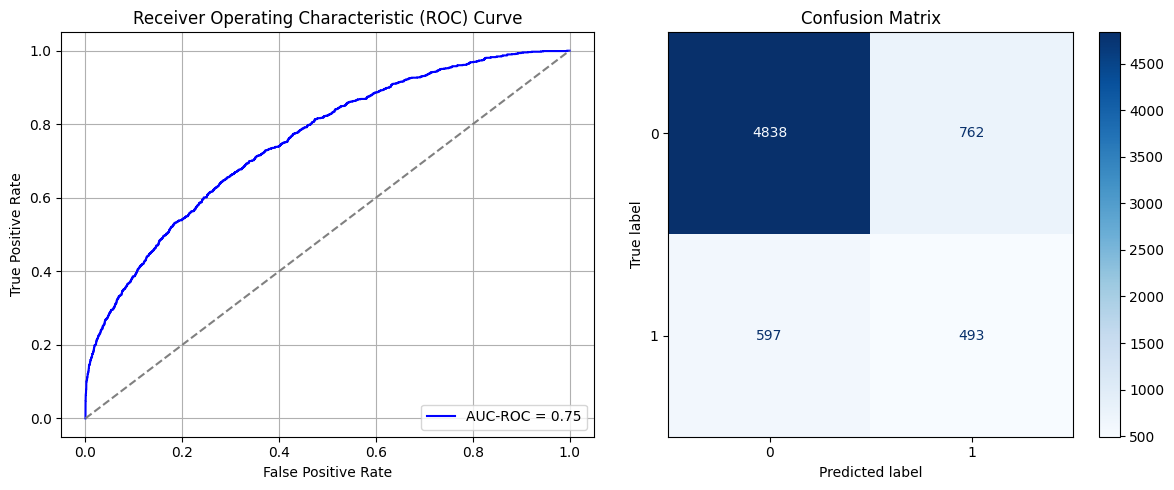

Best threshold based on F1-score: 0.33435267210006714
False Negative Rate: 0.5477064220183486
Time elapsed (performance): 0.8085683160006738
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7410 - loss: 0.5948 - val_AUC: 0.9007 - val_loss: 0.4068
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9072 - loss: 0.3898 - val_AUC: 0.9361 - val_loss: 0.3427
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9396 - loss: 0.3167 - val_AUC: 0.9555 - val_loss: 0.2748
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9539 - loss: 0.2782 - val_AUC: 0.9615 - val_loss: 0.2930
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9585 - loss: 0.2620 - val_AUC: 0.9681 - val_loss: 0.2320
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9642 - loss: 0.2429 - val_AUC: 0.9691 - val_loss: 0.2266
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9674 - loss: 0.2317 - val_AUC: 0.9741 - val_loss: 0.2094
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9712 - loss: 0.2168 - val_AUC: 0.9741 - val_loss: 0.2081
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9733 -

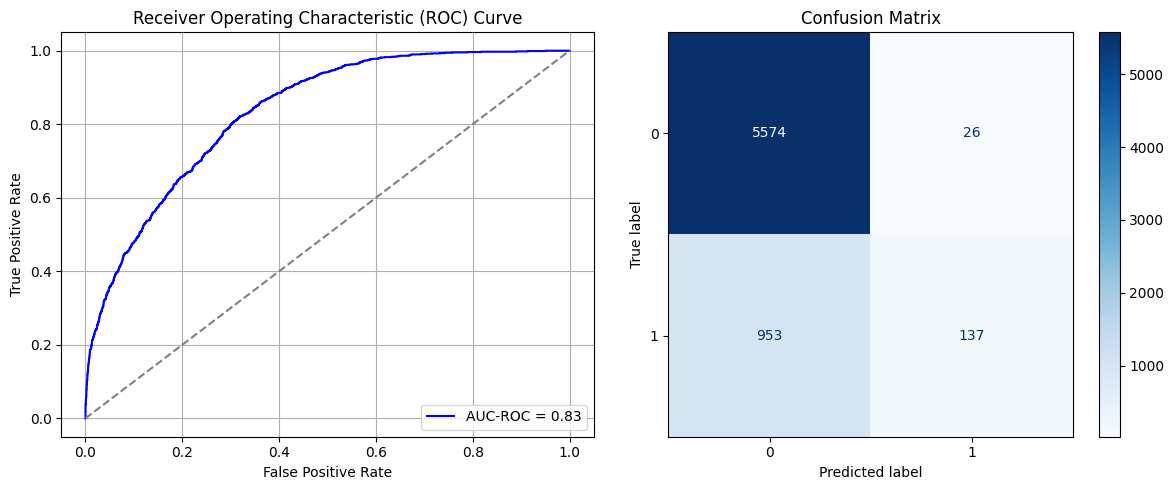

Best threshold based on F1-score: 0.012546874582767487
False Negative Rate: 0.8743119266055046
Time elapsed (performance): 0.7986153290003131
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7453 - loss: 0.5929 - val_AUC: 0.8845 - val_loss: 0.4494
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8891 - loss: 0.4233 - val_AUC: 0.9228 - val_loss: 0.3590
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9289 - loss: 0.3433 - val_AUC: 0.9459 - val_loss: 0.3065
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9480 - loss: 0.2953 - val_AUC: 0.9535 - val_loss: 0.3064
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9581 - loss: 0.2648 - val_AUC: 0.9620 - val_loss: 0.2520
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9624 - loss: 0.2502 - val_AUC: 0.9660 - val_loss: 0.2374
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9673 - loss: 0.2332 - val_AUC: 0.9697 - val_loss: 0.2270
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9707 - loss: 0.2204 - val_AUC: 0.9726 - val_loss: 0.2216
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9720 -

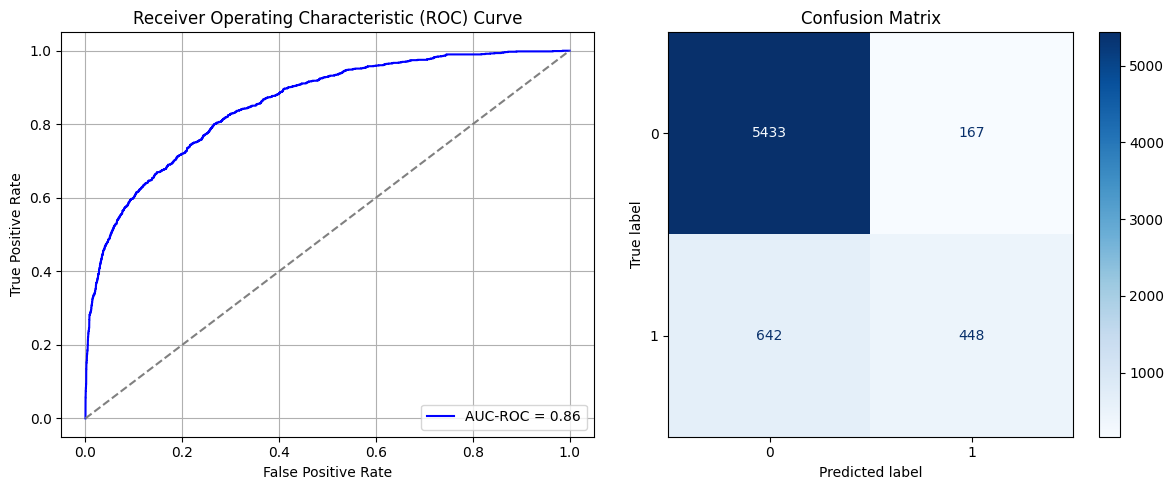

Best threshold based on F1-score: 0.20425160229206085
False Negative Rate: 0.5889908256880734
Time elapsed (performance): 0.7960089779990085
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7464 - loss: 0.5945 - val_AUC: 0.8972 - val_loss: 0.4199
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9005 - loss: 0.4041 - val_AUC: 0.9272 - val_loss: 0.3667
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9340 - loss: 0.3328 - val_AUC: 0.9531 - val_loss: 0.3018
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9459 - loss: 0.3000 - val_AUC: 0.9599 - val_loss: 0.3167
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9576 - loss: 0.2665 - val_AUC: 0.9682 - val_loss: 0.2358
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9621 - loss: 0.2514 - val_AUC: 0.9686 - val_loss: 0.2291
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9668 - loss: 0.2351 - val_AUC: 0.9744 - val_loss: 0.2090
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9712 - loss: 0.2181 - val_AUC: 0.9762 - val_loss: 0.2229
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9735 -

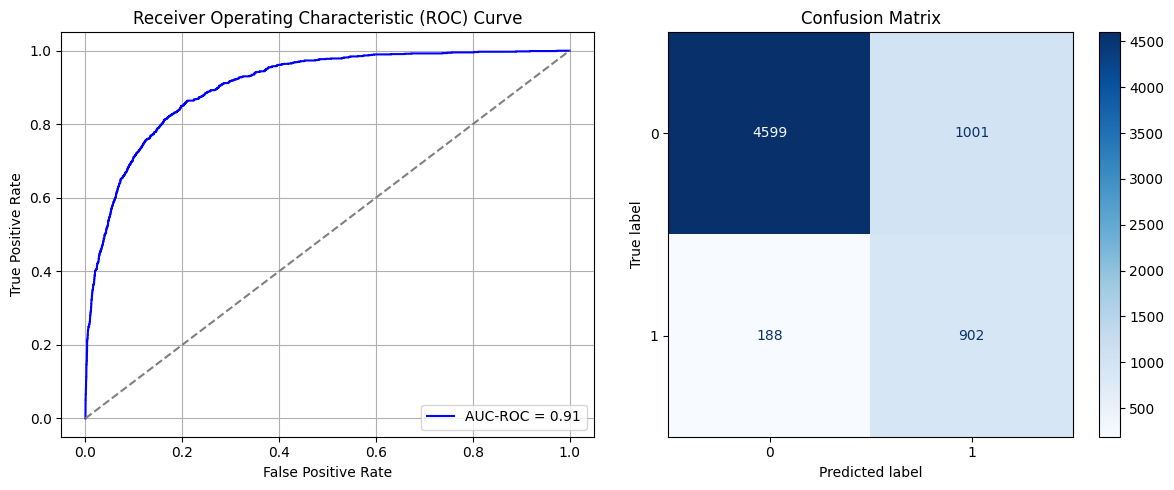

Best threshold based on F1-score: 0.8113312721252441
False Negative Rate: 0.1724770642201835
Time elapsed (performance): 1.113731983999969
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7415 - loss: 0.6011 - val_AUC: 0.8910 - val_loss: 0.4316
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8902 - loss: 0.4231 - val_AUC: 0.9315 - val_loss: 0.3499
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9315 - loss: 0.3400 - val_AUC: 0.9507 - val_loss: 0.2929
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9418 - loss: 0.3106 - val_AUC: 0.9612 - val_loss: 0.2688
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9542 - loss: 0.2756 - val_AUC: 0.9654 - val_loss: 0.2434
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9611 - loss: 0.2553 - val_AUC: 0.9697 - val_loss: 0.2304
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9643 - loss: 0.2439 - val_AUC: 0.9715 - val_loss: 0.2272
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9684 - loss: 0.2282 - val_AUC: 0.9721 - val_loss: 0.2158
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9715 -

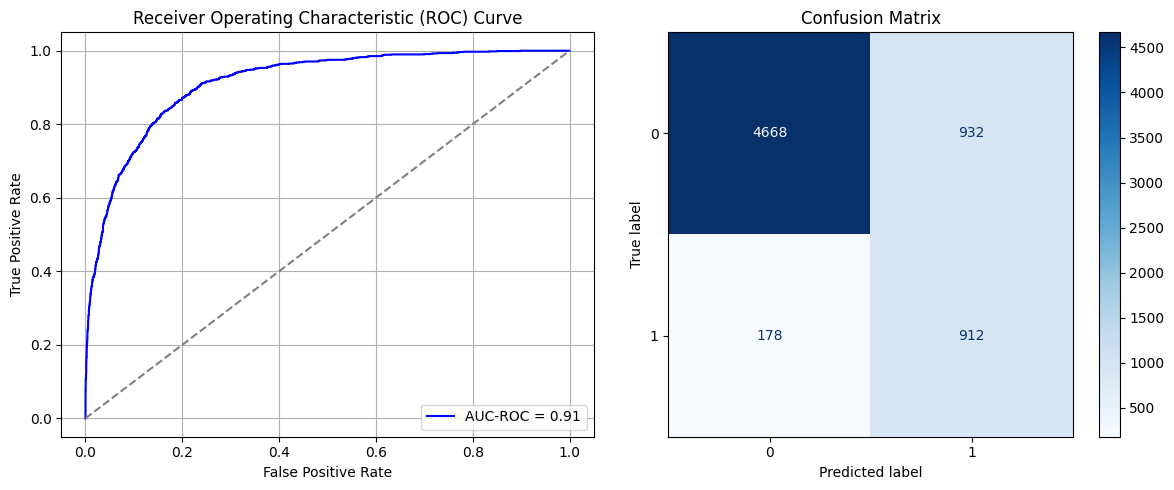

Best threshold based on F1-score: 0.8207685947418213
False Negative Rate: 0.163302752293578
Time elapsed (performance): 1.2493304039999202
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7271 - loss: 0.6090 - val_AUC: 0.8841 - val_loss: 0.4495
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8900 - loss: 0.4224 - val_AUC: 0.9241 - val_loss: 0.3812
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9277 - loss: 0.3474 - val_AUC: 0.9442 - val_loss: 0.3198
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9442 - loss: 0.3049 - val_AUC: 0.9562 - val_loss: 0.2800
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9555 - loss: 0.2727 - val_AUC: 0.9591 - val_loss: 0.2700
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9623 - loss: 0.2508 - val_AUC: 0.9651 - val_loss: 0.2688
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9647 - loss: 0.2422 - val_AUC: 0.9677 - val_loss: 0.2475
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9675 - loss: 0.2319 - val_AUC: 0.9691 - val_loss: 0.2351
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9706 -

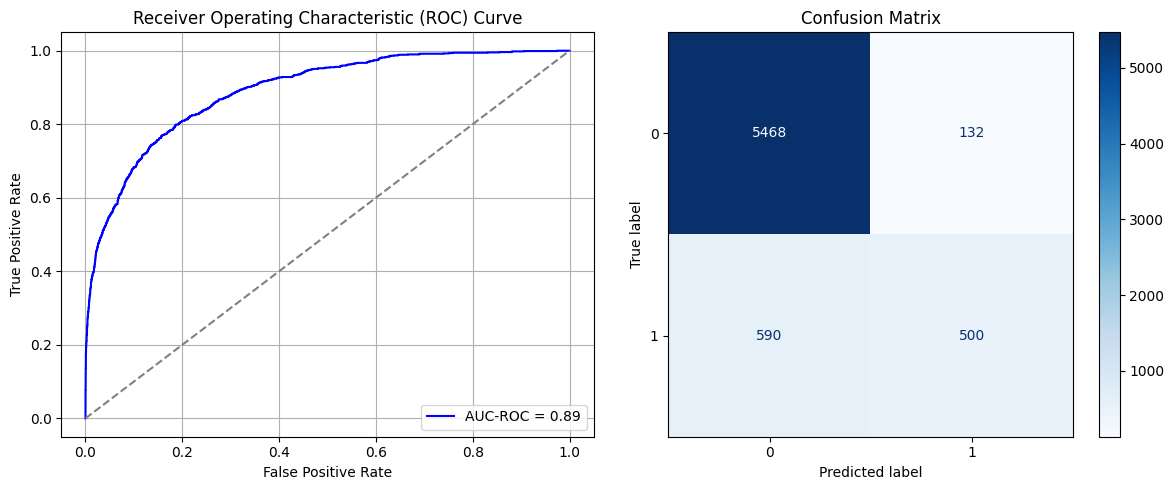

Best threshold based on F1-score: 0.17906124889850616
False Negative Rate: 0.5412844036697247
Time elapsed (performance): 0.7974340700002358
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7549 - loss: 0.5871 - val_AUC: 0.9024 - val_loss: 0.4065
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9104 - loss: 0.3875 - val_AUC: 0.9414 - val_loss: 0.3326
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9414 - loss: 0.3155 - val_AUC: 0.9584 - val_loss: 0.2718
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9541 - loss: 0.2784 - val_AUC: 0.9651 - val_loss: 0.2488
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9609 - loss: 0.2561 - val_AUC: 0.9694 - val_loss: 0.2283
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9667 - loss: 0.2350 - val_AUC: 0.9706 - val_loss: 0.2853
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9692 - loss: 0.2257 - val_AUC: 0.9735 - val_loss: 0.2646
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9716 - loss: 0.2167 - val_AUC: 0.9749 - val_loss: 0.2073
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9736 -

Best threshold based on F1-score: 0.2756762206554413
False Negative Rate: 0.4651376146788991
Time elapsed (performance): 1.106673217000207
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7372 - loss: 0.6027 - val_AUC: 0.8913 - val_loss: 0.4464
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8865 - loss: 0.4262 - val_AUC: 0.9242 - val_loss: 0.3620
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9182 - loss: 0.3666 - val_AUC: 0.9450 - val_loss: 0.3139
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9357 - loss: 0.3255 - val_AUC: 0.9524 - val_loss: 0.2923
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9511 - loss: 0.2858 - val_AUC: 0.9655 - val_loss: 0.2429
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9580 - loss: 0.2645 - val_AUC: 0.9676 - val_loss: 0.2429
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9635 - loss: 0.2465 - val_AUC: 0.9735 - val_loss: 0.2127
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9676 - loss: 0.2320 - val_AUC: 0.9728 - val_loss: 0.2236
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9715 -

Best threshold based on F1-score: 0.20263570547103882
False Negative Rate: 0.48623853211009177
Time elapsed (performance): 0.8597055940008431
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7412 - loss: 0.5986 - val_AUC: 0.8729 - val_loss: 0.4759
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8832 - loss: 0.4326 - val_AUC: 0.9137 - val_loss: 0.3757
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9186 - loss: 0.3658 - val_AUC: 0.9410 - val_loss: 0.3209
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9389 - loss: 0.3179 - val_AUC: 0.9541 - val_loss: 0.2784
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9537 - loss: 0.2787 - val_AUC: 0.9592 - val_loss: 0.2632
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9595 - loss: 0.2591 - val_AUC: 0.9625 - val_loss: 0.2886
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9647 - loss: 0.2417 - val_AUC: 0.9695 - val_loss: 0.2470
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9691 - loss: 0.2267 - val_AUC: 0.9744 - val_loss: 0.2168
Epoch 9/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9726 -

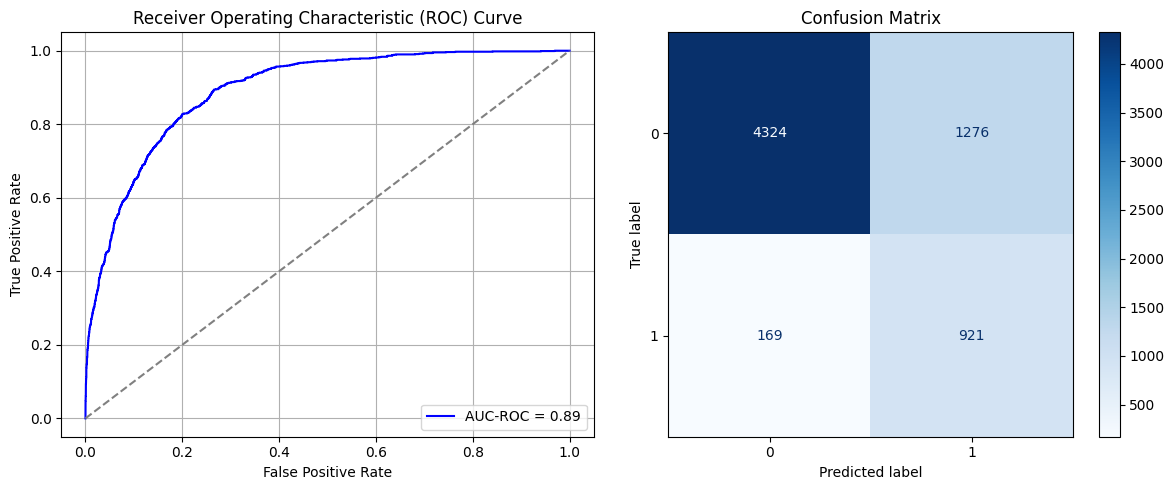

Best threshold based on F1-score: 0.771129310131073
False Negative Rate: 0.15504587155963304
Time elapsed (performance): 1.3348967960009759


In [54]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_S_SRS_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_SRS_ROS = data_S_SRS_ROS.iloc[:, :-1]
    y_S_SRS_ROS = data_S_SRS_ROS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS_ROS, y_S_SRS_ROS, test_size=0.20, random_state=0)
    model_SRS_ROS = create_dnn_model(X_S_train.shape[1])
    result_SRS_ROS = train_and_evaluate(model_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS_ROS = Transductive_TL(model_SRS_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS_ROS)
    FPR.append(result_TL_SRS_ROS[0])
    TNR.append(result_TL_SRS_ROS[1])
    FNR.append(result_TL_SRS_ROS[2])
    TPR.append(result_TL_SRS_ROS[3])
    TL_time.append(result_TL_SRS_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [55]:
print('Mean:', ParamFit['FNR'].mean())
print('Variance:', ParamFit['FNR'].var())

Mean: 0.4063302752293579
Variance: 0.06569227244246181


In [56]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS2.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    32.564528  0.535357  0.464643  0.068807  0.931193     0.920509
1    35.508220  0.136071  0.863929  0.547706  0.452294     0.808568
2    30.995266  0.004643  0.995357  0.874312  0.125688     0.798615
3    37.976346  0.029821  0.970179  0.588991  0.411009     0.796009
4    36.495617  0.178750  0.821250  0.172477  0.827523     1.113732
5    29.631826  0.166429  0.833571  0.163303  0.836697     1.249330
6    33.175167  0.023571  0.976429  0.541284  0.458716     0.797434
7    31.600681  0.057321  0.942679  0.465138  0.534862     1.106673
8    38.494247  0.017679  0.982321  0.486239  0.513761     0.859706
9    32.504215  0.227857  0.772143  0.155046  0.844954     1.334897


## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, we take $k=10$.

In [57]:
data_S
data_S_majority = data_S[data_S['Y'].isin([0])]
data_S_minority = data_S[data_S['Y'].isin([1])]

undersample_size = data_S_minority['Y'].size
oversample_size = data_S_majority['Y'].size

print(undersample_size)
print(oversample_size)

3910
19400


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.7455 - loss: 0.5932 - val_AUC: 0.8809 - val_loss: 0.4421
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8917 - loss: 0.4191 - val_AUC: 0.9271 - val_loss: 0.3585
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9322 - loss: 0.3373 - val_AUC: 0.9481 - val_loss: 0.2982
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9519 - loss: 0.2859 - val_AUC: 0.9585 - val_loss: 0.2794
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9603 - loss: 0.2577 - val_AUC: 0.9670 - val_loss: 0.2397
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9609 - loss: 0.2542 - val_AUC: 0.9685 - val_loss: 0.2299
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9695 - loss: 0.2249 - val_AUC: 0.9730 - val_loss: 0.2355
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9696 - loss: 0.2233 - val_AUC: 0.9750 - val_loss: 0.2116
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9732 -

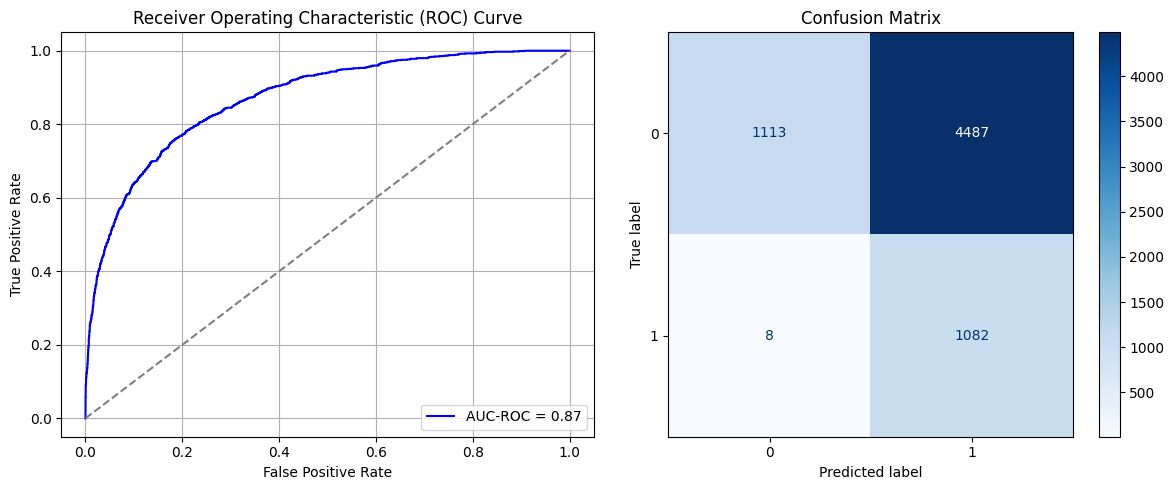

Best threshold based on F1-score: 0.99567049741745
False Negative Rate: 0.007339449541284404
Time elapsed (performance): 0.8901652900003683
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7267 - loss: 0.6069 - val_AUC: 0.9043 - val_loss: 0.4095
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9023 - loss: 0.4015 - val_AUC: 0.9348 - val_loss: 0.3380
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9348 - loss: 0.3300 - val_AUC: 0.9490 - val_loss: 0.3118
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9490 - loss: 0.2927 - val_AUC: 0.9598 - val_loss: 0.2750
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9550 - loss: 0.2743 - val_AUC: 0.9643 - val_loss: 0.2465
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9585 - loss: 0.2622 - val_AUC: 0.9667 - val_loss: 0.2431
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9638 - loss: 0.2451 - val_AUC: 0.9708 - val_loss: 0.2350
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9662 - loss: 0.2361 - val_AUC: 0.9732 - val_loss: 0.2386
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9703 -

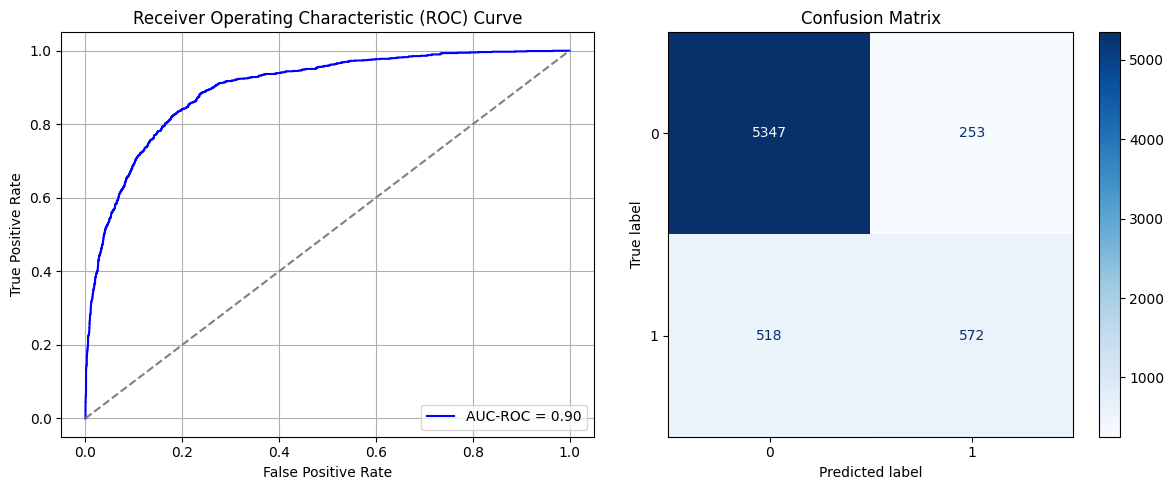

Best threshold based on F1-score: 0.21678544580936432
False Negative Rate: 0.47522935779816516
Time elapsed (performance): 0.9189065549999214
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7214 - loss: 0.6074 - val_AUC: 0.9021 - val_loss: 0.4153
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9046 - loss: 0.3988 - val_AUC: 0.9379 - val_loss: 0.3338
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9382 - loss: 0.3232 - val_AUC: 0.9559 - val_loss: 0.2909
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9541 - loss: 0.2786 - val_AUC: 0.9634 - val_loss: 0.2505
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9621 - loss: 0.2525 - val_AUC: 0.9662 - val_loss: 0.2432
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9647 - loss: 0.2412 - val_AUC: 0.9698 - val_loss: 0.2272
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9686 - loss: 0.2271 - val_AUC: 0.9726 - val_loss: 0.2280
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9701 - loss: 0.2218 - val_AUC: 0.9740 - val_loss: 0.2101
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9732 -

Best threshold based on F1-score: 0.14681066572666168
False Negative Rate: 0.5541284403669725
Time elapsed (performance): 0.9032438150006783
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7254 - loss: 0.6125 - val_AUC: 0.8830 - val_loss: 0.4446
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8918 - loss: 0.4207 - val_AUC: 0.9215 - val_loss: 0.3681
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9202 - loss: 0.3630 - val_AUC: 0.9410 - val_loss: 0.3165
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9413 - loss: 0.3133 - val_AUC: 0.9512 - val_loss: 0.3122
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9501 - loss: 0.2886 - val_AUC: 0.9544 - val_loss: 0.2771
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9552 - loss: 0.2730 - val_AUC: 0.9606 - val_loss: 0.2819
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9613 - loss: 0.2540 - val_AUC: 0.9662 - val_loss: 0.2390
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9640 - loss: 0.2448 - val_AUC: 0.9678 - val_loss: 0.2425
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9679 -

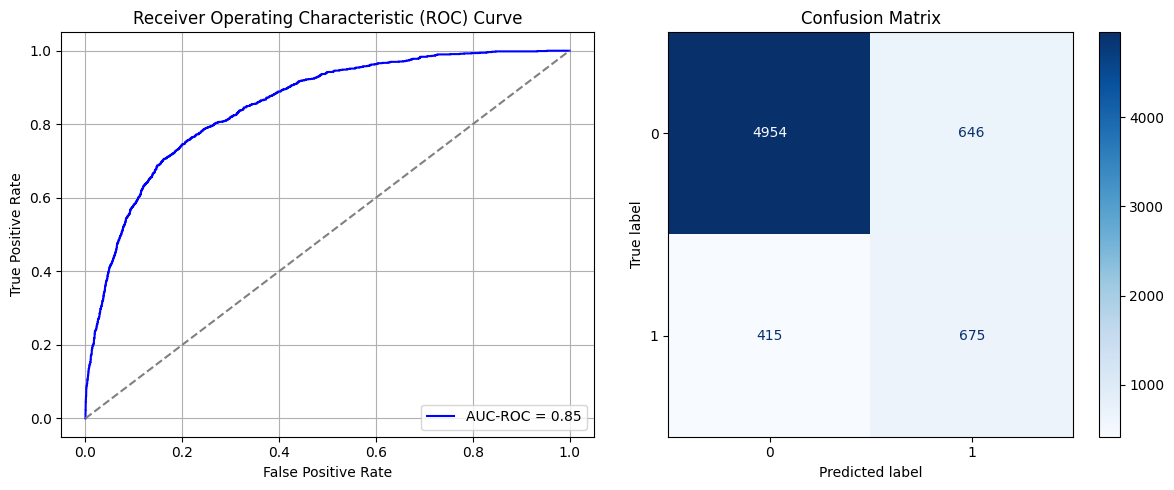

Best threshold based on F1-score: 0.4843218922615051
False Negative Rate: 0.38073394495412843
Time elapsed (performance): 0.8730601070001285
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7583 - loss: 0.5899 - val_AUC: 0.8895 - val_loss: 0.4344
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8914 - loss: 0.4194 - val_AUC: 0.9291 - val_loss: 0.3464
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9286 - loss: 0.3447 - val_AUC: 0.9479 - val_loss: 0.2968
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9457 - loss: 0.3021 - val_AUC: 0.9586 - val_loss: 0.2661
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9549 - loss: 0.2739 - val_AUC: 0.9622 - val_loss: 0.2536
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9605 - loss: 0.2561 - val_AUC: 0.9673 - val_loss: 0.2367
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9656 - loss: 0.2383 - val_AUC: 0.9700 - val_loss: 0.2237
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9679 - loss: 0.2311 - val_AUC: 0.9722 - val_loss: 0.2316
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9696 -

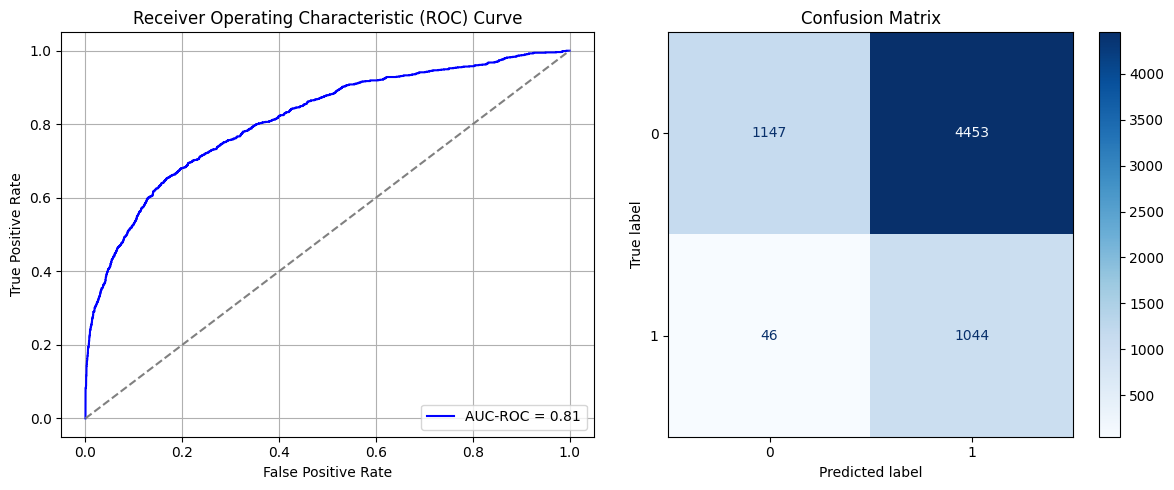

Best threshold based on F1-score: 0.9858126640319824
False Negative Rate: 0.04220183486238532
Time elapsed (performance): 0.8546371979991818
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7470 - loss: 0.5925 - val_AUC: 0.8913 - val_loss: 0.4300
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8975 - loss: 0.4101 - val_AUC: 0.9318 - val_loss: 0.3410
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9313 - loss: 0.3392 - val_AUC: 0.9508 - val_loss: 0.3071
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9500 - loss: 0.2909 - val_AUC: 0.9616 - val_loss: 0.2579
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9613 - loss: 0.2555 - val_AUC: 0.9684 - val_loss: 0.2329
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9619 - loss: 0.2519 - val_AUC: 0.9699 - val_loss: 0.2453
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9690 - loss: 0.2269 - val_AUC: 0.9709 - val_loss: 0.2505
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9711 - loss: 0.2184 - val_AUC: 0.9729 - val_loss: 0.2165
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9730 -

Best threshold based on F1-score: 0.8392797112464905
False Negative Rate: 0.15137614678899083
Time elapsed (performance): 1.0896154649999517
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7344 - loss: 0.6009 - val_AUC: 0.8863 - val_loss: 0.4316
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8937 - loss: 0.4148 - val_AUC: 0.9263 - val_loss: 0.3539
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9270 - loss: 0.3472 - val_AUC: 0.9429 - val_loss: 0.3078
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9458 - loss: 0.3003 - val_AUC: 0.9564 - val_loss: 0.2719
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9563 - loss: 0.2701 - val_AUC: 0.9643 - val_loss: 0.2440
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9639 - loss: 0.2454 - val_AUC: 0.9669 - val_loss: 0.2347
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9677 - loss: 0.2318 - val_AUC: 0.9707 - val_loss: 0.2353
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9701 - loss: 0.2226 - val_AUC: 0.9734 - val_loss: 0.2115
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9731 -

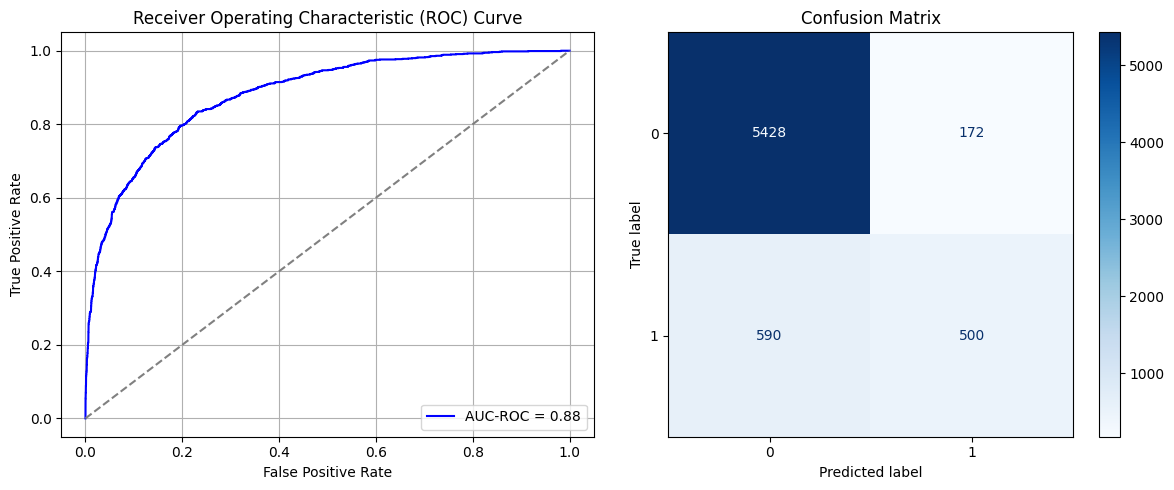

Best threshold based on F1-score: 0.2556891143321991
False Negative Rate: 0.5412844036697247
Time elapsed (performance): 0.9609993869999016
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7283 - loss: 0.6037 - val_AUC: 0.8931 - val_loss: 0.4365
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9017 - loss: 0.4033 - val_AUC: 0.9347 - val_loss: 0.3394
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9353 - loss: 0.3296 - val_AUC: 0.9523 - val_loss: 0.2972
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.9538 - loss: 0.2792 - val_AUC: 0.9631 - val_loss: 0.2553
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9608 - loss: 0.2564 - val_AUC: 0.9661 - val_loss: 0.2393
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.9646 - loss: 0.2426 - val_AUC: 0.9706 - val_loss: 0.2727
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.9677 - loss: 0.2329 - val_AUC: 0.9735 - val_loss: 0.2194
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9719 - loss: 0.2162 - val_AUC: 0.9737 - val_loss: 0.2233
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9740 

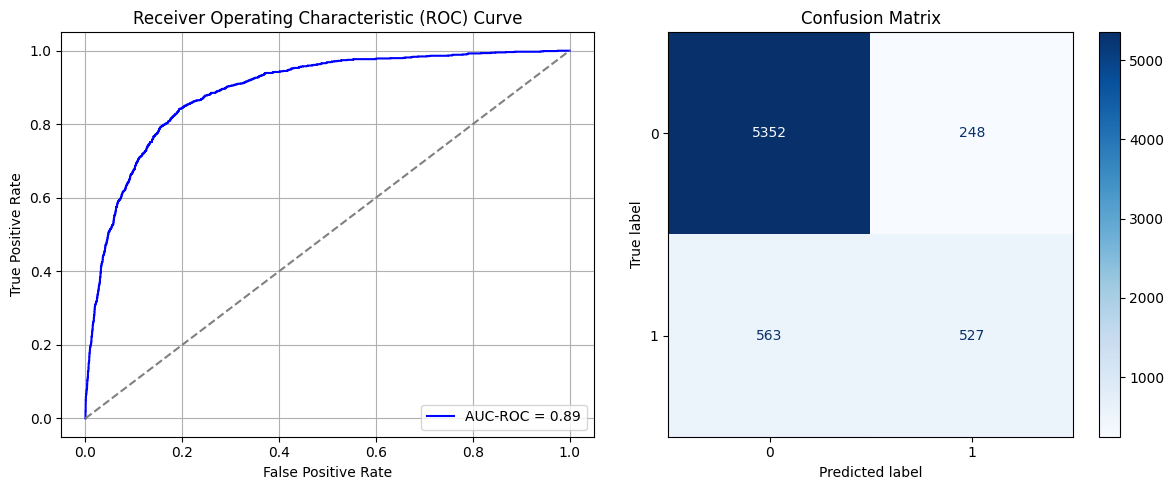

Best threshold based on F1-score: 0.1492464244365692
False Negative Rate: 0.5165137614678899
Time elapsed (performance): 2.0528684820001217
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.7143 - loss: 0.6145 - val_AUC: 0.8901 - val_loss: 0.4316
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.8925 - loss: 0.4188 - val_AUC: 0.9261 - val_loss: 0.3569
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.9285 - loss: 0.3453 - val_AUC: 0.9500 - val_loss: 0.2904
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.9524 - loss: 0.2833 - val_AUC: 0.9651 - val_loss: 0.2618
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9631 - loss: 0.2488 - val_AUC: 0.9706 - val_loss: 0.2289
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9674 - loss: 0.2328 - val_AUC: 0.9712 - val_loss: 0.2376
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9716 - loss: 0.2172 - val_AUC: 0.9740 - val_loss: 0.2063
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9730 - loss: 0.2107 - val_AUC: 0.9754 - val_loss: 0.2190
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9757 -

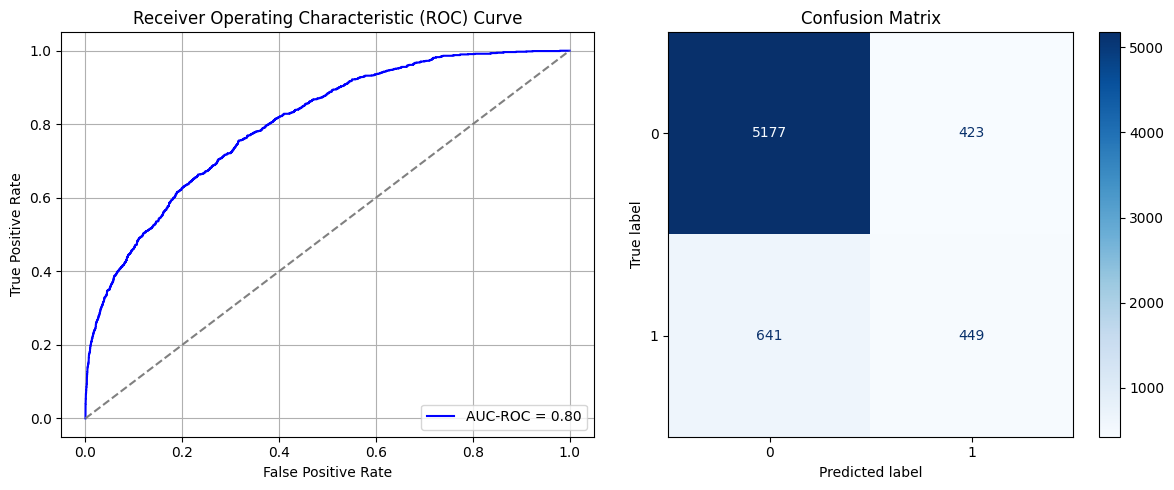

Best threshold based on F1-score: 0.3629598915576935
False Negative Rate: 0.5880733944954128
Time elapsed (performance): 0.877500697000869
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7398 - loss: 0.5989 - val_AUC: 0.8768 - val_loss: 0.4513
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8796 - loss: 0.4383 - val_AUC: 0.9160 - val_loss: 0.3759
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9202 - loss: 0.3625 - val_AUC: 0.9428 - val_loss: 0.3108
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9429 - loss: 0.3084 - val_AUC: 0.9563 - val_loss: 0.2869
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9558 - loss: 0.2715 - val_AUC: 0.9624 - val_loss: 0.2553
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9650 - loss: 0.2416 - val_AUC: 0.9673 - val_loss: 0.2325
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9676 - loss: 0.2310 - val_AUC: 0.9731 - val_loss: 0.2153
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9714 - loss: 0.2168 - val_AUC: 0.9750 - val_loss: 0.2090
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9734 -

Best threshold based on F1-score: 0.7375170588493347
False Negative Rate: 0.42385321100917434
Time elapsed (performance): 1.0978686919988832


In [59]:
times = 10

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = 10
Nsamples = k*(oversample_size-undersample_size)/undersample_size



for i in range(times):
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_S_min_ros = pd.DataFrame()
    data_S_min_ros = data_S_minority.iloc[Row]
    data_S_Sy_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_Sy_ROS = data_S_Sy_ROS.iloc[:, :-1]
    y_S_Sy_ROS = data_S_Sy_ROS.iloc[:, -1]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy_ROS, y_S_Sy_ROS, test_size=0.20, random_state=0)
    model_Sy_ROS = create_dnn_model(X_S_train.shape[1])
    result_Sy_ROS = train_and_evaluate(model_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy_ROS = Transductive_TL(model_Sy_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_Sy_ROS)
    FPR.append(result_TL_Sy_ROS[0])
    TNR.append(result_TL_Sy_ROS[1])
    FNR.append(result_TL_Sy_ROS[2])
    TPR.append(result_TL_Sy_ROS[3])
    TL_time.append(result_TL_Sy_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

In [60]:
print('Mean:', ParamFit['FNR'].mean())
print('Variance:', ParamFit['FNR'].var())

Mean: 0.3680733944954129
Variance: 0.04812067820703458


In [61]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS2.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0    42.755925  0.801250  0.198750  0.007339  0.992661     0.890165
1    36.996564  0.045179  0.954821  0.475229  0.524771     0.918907
2    43.179477  0.083393  0.916607  0.554128  0.445872     0.903244
3    44.587323  0.115357  0.884643  0.380734  0.619266     0.873060
4    35.006051  0.795179  0.204821  0.042202  0.957798     0.854637
5    43.019327  0.264107  0.735893  0.151376  0.848624     1.089615
6    37.155231  0.030714  0.969286  0.541284  0.458716     0.960999
7    54.956779  0.044286  0.955714  0.516514  0.483486     2.052868
8    48.440819  0.075536  0.924464  0.588073  0.411927     0.877501
9    44.287283  0.235000  0.765000  0.423853  0.576147     1.097869
